# Google Analytics Revenue Prediction

Data source: https://www.kaggle.com/colinpearse/ga-analytics-with-json-columns

Origin: https://www.kaggle.com/c/ga-customer-revenue-prediction

## Description
The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

train_v2.csv - the updated training set - contains user transactions from August 1st 2016 to August 1st 2017. <br />
test_v2.csv - the updated test set - contains user transactions from August 2nd 2017 to April 30th 2018.

## Data Fields
- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
totals - This set of columns mostly includes high-level aggregate data.

## Objective / Goal
In this competition, you are challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

## What am I predicting?
We are predicting the natural log of the sum of all transactions (revenue) per user. For each fullVisitorId in the test set, you must predict the natural log of their total revenue in PredictedLogRevenue and also, make predictions for them for those unseen months.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import time

import multiprocessing
cpu_threads = multiprocessing.cpu_count()
print(cpu_threads,'CPU threads')

%matplotlib inline
np.random.seed()

12 CPU threads


In [2]:
prefix = r'./'

## Load Data

In [4]:
df_train = pd.read_csv(prefix + 'data/newtrain.csv')
df_test = pd.read_csv(prefix + 'data/test_df.csv')

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check data is properly loaded

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903645 non-null object
device.browserSize                                   0 non-null float64
device.browserVersion                                0 non-null float64
device.deviceCategory                                903653 non-n

In [5]:
df_train.head()

channelGrouping      date        fullVisitorId  \
0  Organic Search  20160902  1131660440785968503   
1  Organic Search  20160902   377306020877927890   
2  Organic Search  20160902  3895546263509774583   
3  Organic Search  20160902  4763447161404445595   
4  Organic Search  20160902    27294437909732085   

                        sessionId  socialEngagementType     visitId  \
0  1131660440785968503_1472830385  Not Socially Engaged  1472830385   
1   377306020877927890_1472880147  Not Socially Engaged  1472880147   
2  3895546263509774583_1472865386  Not Socially Engaged  1472865386   
3  4763447161404445595_1472881213  Not Socially Engaged  1472881213   
4    27294437909732085_1472822600  Not Socially Engaged  1472822600   

   visitNumber  visitStartTime device.browser  device.browserSize  \
0            1      1472830385         Chrome                 NaN   
1            1      1472880147        Firefox                 NaN   
2            1      1472865386         Chrome                 NaN   
3            1      1472881213     UC Browser                 NaN   
4            2      1472822600         Chrome                 NaN   

           ...           trafficSource.adwordsClickInfo.isVideoAd  \
0          ...                                                NaN   
1          ...                                                NaN   
2          ...                                                NaN   
3          ...                                                NaN   
4          ...                                                NaN   

  trafficSource.adwordsClickInfo.page  trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 NaN                                  NaN   
4                                 NaN                                  NaN   

   trafficSource.campaign  trafficSource.campaignCode  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   

   trafficSource.isTrueDirect  trafficSource.keyword  trafficSource.medium  \
0                         NaN                    NaN               organic   
1                         NaN                    NaN               organic   
2                         NaN                    NaN               organic   
3                         NaN        google + online               organic   
4                        True                    NaN               organic   

   trafficSource.referralPath  trafficSource.source  
0                         NaN                google  
1                         NaN                google  
2                         NaN                google  
3                         NaN                google  
4                         NaN                google  

[5 rows x 55 columns]

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 34 columns):
channelGrouping                                 804684 non-null object
date                                            804684 non-null int64
fullVisitorId                                   804684 non-null object
sessionId                                       804684 non-null object
visitId                                         804684 non-null int64
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null int64
device.browser                                  804684 non-null object
device.deviceCategory                           804684 non-null object
device.isMobile                                 804684 non-null bool
device.operatingSystem                          804684 non-null object
geoNetwork.city                                 804684 non-null object
geoNetwork.continent                       

In [7]:
df_test.head()

channelGrouping      date        fullVisitorId  \
0  Organic Search  20171016  6167871330617112363   
1  Organic Search  20171016  0643697640977915618   
2  Organic Search  20171016  6059383810968229466   
3  Organic Search  20171016  2376720078563423631   
4  Organic Search  20171016  2314544520795440038   

                        sessionId     visitId  visitNumber  visitStartTime  \
0  6167871330617112363_1508151024  1508151024            2      1508151024   
1  0643697640977915618_1508175522  1508175522            1      1508175522   
2  6059383810968229466_1508143220  1508143220            1      1508143220   
3  2376720078563423631_1508193530  1508193530            1      1508193530   
4  2314544520795440038_1508217442  1508217442            1      1508217442   

  device.browser device.deviceCategory  device.isMobile          ...           \
0         Chrome               desktop            False          ...            
1         Chrome               desktop            False          ...            
2         Chrome               desktop            False          ...            
3         Safari                mobile             True          ...            
4         Safari               desktop            False          ...            

  trafficSource.adwordsClickInfo.gclId  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  trafficSource.adwordsClickInfo.isVideoAd  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

  trafficSource.campaign trafficSource.isTrueDirect trafficSource.keyword  \
0              (not set)                       True        (not provided)   
1              (not set)                        NaN        (not provided)   
2              (not set)                        NaN        (not provided)   
3              (not set)                        NaN        (not provided)   
4              (not set)                        NaN        (not provided)   

  trafficSource.medium  trafficSource.referralPath  trafficSource.source  
0              organic                         NaN                google  
1              organic                         NaN                google  
2              organic                         NaN                google  
3              organic                         NaN                google  
4              organic                         NaN                google  

[5 rows x 34 columns]

## Clean Data

In [5]:
# Convert date values to Pandas datetime format
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d', errors='coerce')
df_train['visitStartTime'] = pd.to_datetime(df_train['visitStartTime'], unit='s', errors='coerce')
df_train.sort_values(by='visitStartTime', ascending=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)

# Convert date values to Pandas datetime format
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y%m%d', errors='coerce')
df_test['visitStartTime'] = pd.to_datetime(df_test['visitStartTime'], unit='s', errors='coerce')
df_test.sort_values(by='visitStartTime', ascending=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null datetime64[ns]
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null datetime64[ns]
device.browser                                       903645 non-null object
device.browserSize                                   0 non-null float64
device.browserVersion                                0 non-null float64
device.deviceCategory                          

In [10]:
df_train.head()

channelGrouping       date        fullVisitorId  \
0          Direct 2016-08-01   423043652415339154   
1          Social 2016-08-01  8294721032567046680   
2  Organic Search 2016-08-01  7718623669497357235   
3  Organic Search 2016-08-01  4798058133221713505   
4          Direct 2016-08-01  5076747981380011349   

                        sessionId  socialEngagementType     visitId  \
0  0423043652415339154_1470034812  Not Socially Engaged  1470034812   
1  8294721032567046680_1470035066  Not Socially Engaged  1470035066   
2  7718623669497357235_1470035081  Not Socially Engaged  1470035081   
3  4798058133221713505_1470035161  Not Socially Engaged  1470035161   
4  5076747981380011349_1470035170  Not Socially Engaged  1470035170   

   visitNumber      visitStartTime device.browser  device.browserSize  \
0            3 2016-08-01 07:00:12         Safari                 NaN   
1            1 2016-08-01 07:04:26         Chrome                 NaN   
2            1 2016-08-01 07:04:41    Amazon Silk                 NaN   
3            1 2016-08-01 07:06:01         Chrome                 NaN   
4            1 2016-08-01 07:06:10         Chrome                 NaN   

           ...           trafficSource.adwordsClickInfo.isVideoAd  \
0          ...                                                NaN   
1          ...                                                NaN   
2          ...                                                NaN   
3          ...                                                NaN   
4          ...                                                NaN   

  trafficSource.adwordsClickInfo.page  trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 NaN                                  NaN   
4                                 NaN                                  NaN   

   trafficSource.campaign  trafficSource.campaignCode  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   

   trafficSource.isTrueDirect  trafficSource.keyword  trafficSource.medium  \
0                        True                    NaN                (none)   
1                         NaN                    NaN              referral   
2                         NaN                    NaN               organic   
3                         NaN                    NaN               organic   
4                        True                    NaN                (none)   

   trafficSource.referralPath  trafficSource.source  
0                         NaN              (direct)  
1                  /yt/about/           youtube.com  
2                         NaN                google  
3                         NaN                google  
4                         NaN              (direct)  

[5 rows x 55 columns]

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 34 columns):
channelGrouping                                 804684 non-null object
date                                            804684 non-null datetime64[ns]
fullVisitorId                                   804684 non-null object
sessionId                                       804684 non-null object
visitId                                         804684 non-null int64
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null datetime64[ns]
device.browser                                  804684 non-null object
device.deviceCategory                           804684 non-null object
device.isMobile                                 804684 non-null bool
device.operatingSystem                          804684 non-null object
geoNetwork.city                                 804684 non-null object
geoNetwork.continent     

In [12]:
df_test.head()

channelGrouping       date        fullVisitorId  \
0  Organic Search 2017-08-02  3800266955937177725   
1         Display 2017-08-02  9945591060914032258   
2  Organic Search 2017-08-02  9952572636180683443   
3  Organic Search 2017-08-02  8775495552152201078   
4  Organic Search 2017-08-02   167247604162700002   

                        sessionId     visitId  visitNumber  \
0  3800266955937177725_1501657186  1501657186            3   
1  9945591060914032258_1501656843  1501656843            1   
2  9952572636180683443_1501657166  1501657166            1   
3  8775495552152201078_1501657013  1501657013            1   
4  0167247604162700002_1501656404  1501656404            3   

       visitStartTime     device.browser device.deviceCategory  \
0 2017-08-02 07:00:03  Internet Explorer               desktop   
1 2017-08-02 07:00:13             Chrome                mobile   
2 2017-08-02 07:00:16             Chrome               desktop   
3 2017-08-02 07:00:39             Chrome               desktop   
4 2017-08-02 07:01:20             Chrome               desktop   

   device.isMobile          ...          trafficSource.adwordsClickInfo.gclId  \
0            False          ...                                           NaN   
1             True          ...                                           NaN   
2            False          ...                                           NaN   
3            False          ...                                           NaN   
4            False          ...                                           NaN   

  trafficSource.adwordsClickInfo.isVideoAd  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

  trafficSource.campaign trafficSource.isTrueDirect trafficSource.keyword  \
0              (not set)                       True        (not provided)   
1              (not set)                        NaN                   NaN   
2              (not set)                        NaN        (not provided)   
3              (not set)                        NaN        (not provided)   
4              (not set)                       True        (not provided)   

  trafficSource.medium  trafficSource.referralPath  trafficSource.source  
0              organic                         NaN                google  
1                  cpm                         NaN                google  
2              organic                         NaN                google  
3              organic                         NaN                google  
4              organic                         NaN                google  

[5 rows x 34 columns]

In [13]:
# Remove columns containing all null values
num_of_rows = len(df_train)
nan_cols = []
print('Following columns containing all null values:')
for column in df_train.columns:
    if df_train[column].isnull().sum() == num_of_rows:
        print(column)
        nan_cols.append(column)

if len(nan_cols) > 0:
    df_train.drop(nan_cols, axis=1, inplace=True)

Following columns containing all null values:
device.browserSize
device.browserVersion
device.flashVersion
device.language
device.mobileDeviceBranding
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.mobileDeviceModel
device.mobileInputSelector
device.operatingSystemVersion
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
trafficSource.adwordsClickInfo.criteriaParameters


In [14]:
# Remove columns containing all null values
num_of_rows = len(df_test)
nan_cols = []
print('Following columns containing all null values:')
for column in df_test.columns:
    if df_test[column].isnull().sum() == num_of_rows:
        print(column)
        nan_cols.append(column)

if len(nan_cols) > 0:
    df_test.drop(nan_cols, axis=1, inplace=True)

Following columns containing all null values:


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 38 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null datetime64[ns]
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
socialEngagementType                            903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null datetime64[ns]
device.browser                                  903645 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          898958 non-null object
geoNetwork.city          

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 34 columns):
channelGrouping                                 804684 non-null object
date                                            804684 non-null datetime64[ns]
fullVisitorId                                   804684 non-null object
sessionId                                       804684 non-null object
visitId                                         804684 non-null int64
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null datetime64[ns]
device.browser                                  804684 non-null object
device.deviceCategory                           804684 non-null object
device.isMobile                                 804684 non-null bool
device.operatingSystem                          804684 non-null object
geoNetwork.city                                 804684 non-null object
geoNetwork.continent     

In [17]:
print('Following columns containing some null values:')
for column in df_train.columns:
    null_count = df_train[column].isnull().sum()
    if null_count > 0:
        print(column,'\t\t\t\t',null_count,'null', df_train[column].dtype)

Following columns containing some null values:
device.browser 				 8 null object
device.operatingSystem 				 4695 null object
geoNetwork.city 				 542491 null object
geoNetwork.continent 				 1468 null object
geoNetwork.country 				 1468 null object
geoNetwork.metro 				 709995 null object
geoNetwork.networkDomain 				 244881 null object
geoNetwork.region 				 536056 null object
geoNetwork.subContinent 				 1468 null object
totals.bounces 				 453023 null float64
totals.newVisits 				 200593 null float64
totals.pageviews 				 100 null float64
totals.transactionRevenue 				 892138 null float64
trafficSource.adContent 				 892707 null object
trafficSource.adwordsClickInfo.adNetworkType 				 882193 null object
trafficSource.adwordsClickInfo.gclId 				 882092 null object
trafficSource.adwordsClickInfo.isVideoAd 				 882193 null object
trafficSource.adwordsClickInfo.page 				 882193 null float64
trafficSource.adwordsClickInfo.slot 				 882193 null object
trafficSource.campaign 				 865347 n

In [18]:
print('Following columns containing some null values:')
for column in df_test.columns:
    null_count = df_test[column].isnull().sum()
    if null_count > 0:
        print(column,'\t\t\t\t',null_count,'null', df_test[column].dtype)

Following columns containing some null values:
totals.bounces 				 383736 null float64
totals.newVisits 				 200314 null float64
totals.pageviews 				 139 null float64
trafficSource.adContent 				 750893 null object
trafficSource.adwordsClickInfo.adNetworkType 				 750870 null object
trafficSource.adwordsClickInfo.gclId 				 750822 null object
trafficSource.adwordsClickInfo.isVideoAd 				 750870 null object
trafficSource.adwordsClickInfo.page 				 750870 null float64
trafficSource.adwordsClickInfo.slot 				 750870 null object
trafficSource.isTrueDirect 				 544171 null object
trafficSource.keyword 				 391032 null object
trafficSource.referralPath 				 569361 null object


In [19]:
df_train['channelGrouping'].unique()

array(['Direct', 'Social', 'Organic Search', 'Referral', 'Display',
       'Paid Search', 'Affiliates', '(Other)'], dtype=object)

In [20]:
# IsTrueDirect is relevant only to Channel Grouping of type 'Direct'. 
# Hence, IsTrueDirect is not applicable to other channel grouping types
# IsTrueDirect should have 3 possible outcomes: 'Yes', 'No', 'Not Applicable'
print('Before cleaning:', df_train['trafficSource.isTrueDirect'].unique())
df_train.loc[(df_train['channelGrouping'] == 'Direct') & 
             (df_train['trafficSource.isTrueDirect'] == True), 'trafficSource.isTrueDirect'] = 'Yes'
df_train.loc[(df_train['channelGrouping'] == 'Direct') & 
             (df_train['trafficSource.isTrueDirect'] != 'Yes'), 'trafficSource.isTrueDirect'] = 'No'
df_train.loc[(df_train['channelGrouping'] != 'Direct'), 
             'trafficSource.isTrueDirect'] = 'Not Applicable'
print('After cleaning:', df_train['trafficSource.isTrueDirect'].unique())

Before cleaning: [True nan]
After cleaning: ['Yes' 'Not Applicable' 'No']


In [21]:
# IsTrueDirect is relevant only to Channel Grouping of type 'Direct'. 
# Hence, IsTrueDirect is not applicable to other channel grouping types
# IsTrueDirect should have 3 possible outcomes: 'Yes', 'No', 'Not Applicable'
print('Before cleaning:', df_test['trafficSource.isTrueDirect'].unique())
df_test.loc[(df_test['channelGrouping'] == 'Direct') & 
             (df_test['trafficSource.isTrueDirect'] == True), 'trafficSource.isTrueDirect'] = 'Yes'
df_test.loc[(df_test['channelGrouping'] == 'Direct') & 
             (df_test['trafficSource.isTrueDirect'] != 'Yes'), 'trafficSource.isTrueDirect'] = 'No'
df_test.loc[(df_test['channelGrouping'] != 'Direct'), 
             'trafficSource.isTrueDirect'] = 'Not Applicable'
print('After cleaning:', df_test['trafficSource.isTrueDirect'].unique())

Before cleaning: [True nan]
After cleaning: ['Not Applicable' 'Yes']


In [22]:
# Following columns with NaN values can replace with: 
# none - indicating no value is provided
# unknown - indicating value is not known
# 0.0 - for column with binary outcomes or in logical numeric range
df_train['trafficSource.keyword'].fillna('none', inplace=True)
df_train['totals.bounces'].fillna(0.0, inplace=True)
df_train['totals.newVisits'].fillna(0.0, inplace=True)
df_train['totals.pageviews'].fillna(0.0, inplace=True)
df_train['totals.transactionRevenue'].fillna(0.0, inplace=True)
df_train['trafficSource.referralPath'].fillna('none', inplace=True)
df_train['trafficSource.source'].fillna('none', inplace=True)
df_train['geoNetwork.metro'].fillna('unknown', inplace=True)
df_train['geoNetwork.networkDomain'].fillna('unknown', inplace=True)
df_train['device.browser'].fillna('unknown', inplace=True)
# Build a classifier and predict NA values?
df_train['device.operatingSystem'].fillna('unknown', inplace=True) 

In [23]:
# Following columns with NaN values can replace with: 
# none - indicating no value is provided
# unknown - indicating value is not known
# 0.0 - for column with binary outcomes or in logical numeric range
df_test['trafficSource.keyword'].fillna('none', inplace=True)
df_test['totals.bounces'].fillna(0.0, inplace=True)
df_test['totals.newVisits'].fillna(0.0, inplace=True)
df_test['totals.pageviews'].fillna(0.0, inplace=True)
df_test['trafficSource.referralPath'].fillna('none', inplace=True)
df_test['trafficSource.source'].fillna('none', inplace=True)
df_test['geoNetwork.metro'].fillna('unknown', inplace=True)
df_test['geoNetwork.networkDomain'].fillna('unknown', inplace=True)
df_test['device.browser'].fillna('unknown', inplace=True)
# Build a classifier and predict NA values?
df_test['device.operatingSystem'].fillna('unknown', inplace=True) 

In [24]:
for domain in df_train.loc[:, 'geoNetwork.networkDomain'].unique():
    if 'unknown' in domain: # standardize invalid domain names to 'unkonwn'
        print(domain)
        df_train.replace(domain, value='unknown', inplace=True)

unknown
unknown.unknown
unknown.com.ua
unknown.ru
unknown.ua
unknown.com
unknown.pl
unknown.info
unknown.org
unknown.se
unknown.net
unknown.it
unknown.as34268
unknown.com.pk
unknown.ac.ru
unknown.ca
unknown.com.br
unknown.ro
unknown.com.ar
unknown.net.au
unknown.es
unknown.fr
unknown.in
unknown.wa.us
unknown.de
unknown.al.us
unknown.com.my
unknown.net.hk
unknown.nl
unknown.ie
unknown.be
unknown.co.za
unknown.cl
unknown.ee


In [25]:
for domain in df_test.loc[:, 'geoNetwork.networkDomain'].unique():
    if 'unknown' in domain: # standardize invalid domain names to 'unkonwn'
        print(domain)
        df_test.replace(domain, value='unknown', inplace=True)

unknown.unknown
unknown.com
unknown.net
unknown.net.au
unknown.gm
unknown.se
unknown.cz
unknown.net.pl
unknown.com.br
unknown.com.ph
unknown.org.br
unknown.com.au
unknown.ca.us
unknown.de
unknown.nl
unknown.co.nz
unknown.fi
unknown.ac.th
unknown.be
unknown.la
unknown.pl
unknown.info
unknown.co.uk
unknown.it
unknown.co.kr
unknown.org
unknown.co.id
unknown.com.sg
unknown.edu.pe
unknown.ua
unknown.co.il
unknown.ru
unknown.edu.ph
unknown.hn
unknown.travel
unknown.lk
unknown.co.th


In [26]:
# Remove Google DEPRECATED column
# DEPRECATED column values add noises as the data format is no longer maintained and managed 
deprecated_cols = ['device.isMobile']
if set(deprecated_cols).issubset(df_train.columns):
    df_train.drop(deprecated_cols, axis=1, inplace=True)

In [27]:
# Remove Google DEPRECATED column
# DEPRECATED column values add noises as the data format is no longer maintained and managed 
deprecated_cols = ['device.isMobile']
if set(deprecated_cols).issubset(df_test.columns):
    df_test.drop(deprecated_cols, axis=1, inplace=True)

In [28]:
df_train['channelGrouping'].unique()

array(['Direct', 'Social', 'Organic Search', 'Referral', 'Display',
       'Paid Search', 'Affiliates', '(Other)'], dtype=object)

In [29]:
df_train[(~df_train['trafficSource.adContent'].isnull())]['channelGrouping'].unique()

array(['Paid Search', 'Affiliates'], dtype=object)

In [30]:
# adContent is only valid for Channel Groups of type 'Paid Search', 'Display' or 'Affiliates' 
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.adContent'].unique())
df_train.loc[(df_train['trafficSource.adContent'].isnull()) &
             ((df_train['channelGrouping'] == 'Paid Search') |
              (df_train['channelGrouping'] == 'Display') |
              (df_train['channelGrouping'] == 'Affiliates')),
             'trafficSource.adContent'] = 'unknown'
df_train.loc[(df_train['trafficSource.adContent'].isnull()) &
             (df_train['channelGrouping'] != 'Paid Search') &
             (df_train['channelGrouping'] != 'Display') &
             (df_train['channelGrouping'] != 'Affiliates'),
             'trafficSource.adContent'] = 'none'
print('After cleaning for \'Paid Search\' and \'Affiliates\' channels:', 
      pd.unique(df_train.loc[((df_train['channelGrouping'] == 'Paid Search') |
                              (df_train['channelGrouping'] == 'Display') |
                              (df_train['channelGrouping'] == 'Affiliates')), 
                             'trafficSource.adContent']))
print('After cleaning for other channels:', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                             (df_train['channelGrouping'] != 'Display') &
                             (df_train['channelGrouping'] != 'Affiliates'), 
                             'trafficSource.adContent']))

Before cleaning: [nan '20% discount' 'Full auto ad IMAGE ONLY'
 'Official Google Merchandise - Fast Shipping' 'Google Merchandise'
 'Free Shipping!' 'First Full Auto Template Test Ad'
 'Full auto ad TEXT/NATIVE' 'Swag w/ Google Logos'
 'Display Ad created 3/11/14' 'Full auto ad with Primary Color'
 'free shipping' '{KeyWord:Google Brand Items}' 'GA Help Center'
 'Display Ad created 3/11/15' 'Full auto ad NATIVE ONLY' 'Ad from 11/3/16'
 'Ad from 11/7/16' 'Full auto ad TEXT ONLY' 'JD_5a_v1'
 "{KeyWord:Google Men's T-Shirts}" 'LeEco_1a'
 '{KeyWord:Google Branded Outerwear}' 'Ad from 12/13/16' 'url_builder'
 'Google Online Store' '{KeyWord:Google Merchandise}'
 'Google Merchandise Collection' '{KeyWord:Google Branded Gear}'
 'Swag with Google Logos' 'Google Paraphernalia'
 '{KeyWord:Google Branded Kit}' 'Ad from 2/17/17'
 '{KeyWord:Looking for Google Bags?}' 'visit us again'
 '{KeyWord:Google Branded Apparel}' '{KeyWord:Google Drinkware}'
 '{KeyWord:Want Google Stickers?}' 'Want Google Sun

In [31]:
df_test[(~df_test['trafficSource.adContent'].isnull())]['channelGrouping'].unique()

array(['Paid Search', 'Display', 'Affiliates'], dtype=object)

In [32]:
# adContent is only valid for Channel Groups of type 'Paid Search', 'Display' or 'Affiliates' 
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.adContent'].unique())
df_test.loc[(df_test['trafficSource.adContent'].isnull()) &
             ((df_test['channelGrouping'] == 'Paid Search') |
              (df_test['channelGrouping'] == 'Display') |
              (df_test['channelGrouping'] == 'Affiliates')),
             'trafficSource.adContent'] = 'unknown'
df_test.loc[(df_test['trafficSource.adContent'].isnull()) &
             (df_test['channelGrouping'] != 'Paid Search') &
             (df_test['channelGrouping'] != 'Display') &
             (df_test['channelGrouping'] != 'Affiliates'),
             'trafficSource.adContent'] = 'none'
print('After cleaning for \'Paid Search\' and \'Affiliates\' channels:', 
      pd.unique(df_test.loc[((df_test['channelGrouping'] == 'Paid Search') |
                              (df_test['channelGrouping'] == 'Display') |
                              (df_test['channelGrouping'] == 'Affiliates')), 
                             'trafficSource.adContent']))
print('After cleaning for other channels:', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                             (df_test['channelGrouping'] != 'Display') &
                             (df_test['channelGrouping'] != 'Affiliates'), 
                             'trafficSource.adContent']))

Before cleaning: [nan 'Display Ad created 3/11/14' 'Google Merchandise Collection'
 'Google Online Store' 'Google Merchandise Store' 'visit us again' 'cool'
 'Placememnt Drinkware 160x600' 'Bags 300x250'
 'Placement Electronics 160 x 600' 'Placement Elecronics 300 x 250'
 'Placement Accessories 300 x 250' 'Office Placement 160x600'
 'Bags 336x280' 'Placement Office 300x250' 'Placement Office 336x280'
 'Placement Drinkware 300x250' 'Placement 336x280' 'Bags 160 x 600'
 'Official Google Merchandise' 'Placement Accessories 160 x 600'
 'Drinkware 336x280' 'test_tyler_hr_merchant'
 'Accessories Placement 336 x 280' '{KeyWord:Google Branded Gear}'
 'Google Store' 'Ad from 12/15/17' 'Placement Accessores 300 x 250'
 'Placement Accessories 336 x 280' '{KeyWord:Google Brand Items}'
 '{KeyWord:Google Merchandise}' 'Smart display ad - 8/17/2017'
 '{KeyWord:Google Branded Kit}' '{KeyWord:Google Drinkware}'
 'Swag with Google Logos' '{KeyWord:Want Google Stickers?}'
 '{KeyWord:Looking for Google Ba

In [33]:
df_train[(~df_train['trafficSource.adwordsClickInfo.adNetworkType'].isnull())]\
        ['channelGrouping'].unique()

array(['Paid Search'], dtype=object)

In [34]:
df_test[(~df_test['trafficSource.adwordsClickInfo.adNetworkType'].isnull())]\
        ['channelGrouping'].unique()

array(['Paid Search', 'Display'], dtype=object)

In [35]:
# trafficSource.adwordsClickInfo.adNetworkType is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.adwordsClickInfo.adNetworkType'].unique())
df_train.loc[(df_train['trafficSource.adwordsClickInfo.adNetworkType'].isnull()) &
             ((df_train['channelGrouping'] == 'Display') |
             (df_train['channelGrouping'] == 'Paid Search')),
             'trafficSource.adwordsClickInfo.adNetworkType'] = 'unknown'
df_train.loc[(df_train['trafficSource.adwordsClickInfo.adNetworkType'].isnull()) &
             ((df_train['channelGrouping'] != 'Display') |
             (df_train['channelGrouping'] != 'Paid Search')),
             'trafficSource.adwordsClickInfo.adNetworkType'] = 'none'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] == 'Paid Search') |
                             (df_train['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.adNetworkType']))
print('After cleaning for other channels:', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                             (df_train['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.adNetworkType']))

Before cleaning: [nan 'Google Search' 'Search partners']
After cleaning for 'Paid Search' channel : ['unknown' 'Google Search' 'Search partners']
After cleaning for other channels: ['none']


In [36]:
# trafficSource.adwordsClickInfo.adNetworkType is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.adwordsClickInfo.adNetworkType'].unique())
df_test.loc[(df_test['trafficSource.adwordsClickInfo.adNetworkType'].isnull()) &
             ((df_test['channelGrouping'] == 'Display') |
             (df_test['channelGrouping'] == 'Paid Search')),
             'trafficSource.adwordsClickInfo.adNetworkType'] = 'unknown'
df_test.loc[(df_test['trafficSource.adwordsClickInfo.adNetworkType'].isnull()) &
             ((df_test['channelGrouping'] != 'Display') |
             (df_test['channelGrouping'] != 'Paid Search')),
             'trafficSource.adwordsClickInfo.adNetworkType'] = 'none'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] == 'Paid Search') |
                             (df_test['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.adNetworkType']))
print('After cleaning for other channels:', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                             (df_test['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.adNetworkType']))

Before cleaning: [nan 'Google Search' 'Content' 'Search partners']
After cleaning for 'Paid Search' channel : ['unknown' 'Google Search' 'Content' 'Search partners']
After cleaning for other channels: ['none']


In [37]:
df_train[(~df_train['trafficSource.adwordsClickInfo.gclId'].isnull())]['channelGrouping'].unique()

array(['Paid Search'], dtype=object)

In [38]:
df_test[(~df_test['trafficSource.adwordsClickInfo.gclId'].isnull())]['channelGrouping'].unique()

array(['Paid Search', 'Display'], dtype=object)

In [39]:
# trafficSource.adwordsClickInfo.gclId is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.adwordsClickInfo.gclId'].unique())
df_train.loc[(df_train['trafficSource.adwordsClickInfo.gclId'].isnull()) &
             ((df_train['channelGrouping'] == 'Paid Search') |
              (df_train['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.gclId'] = 'unknown'
df_train.loc[(df_train['trafficSource.adwordsClickInfo.gclId'].isnull()) &
             (df_train['channelGrouping'] != 'Paid Search') &
             (df_train['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.gclId'] = 'none'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] == 'Paid Search') |
                             (df_train['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.gclId']))
print('After cleaning for other channels:', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                             (df_train['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.gclId']))

Before cleaning: [nan 'CMO7jYbm48sCFUdrfgod1MAP1w' 'CPSfsJuXgM4CFQGRfgodWFYBxA' ...
 'EAIaIQobChMI-cb0zOK31QIVglh-Ch3dXAQJEAAYASAAEgITJvD_BwE'
 'CjwKCAjwzYDMBRA1EiwAwCv6Js2UmHilbcpgOqLzds04feuO6QamW11R7dya5vPrthNhQhMuoeWbXhoCJBMQAvD_BwE'
 'CjwKCAjwzYDMBRA1EiwAwCv6JilEGW3vfHbo3X1x-AvARKB1b7Fh9fr9veOI_43yWICG7jerzbX31BoCCioQAvD_BwE']
After cleaning for 'Paid Search' channel : ['unknown' 'CMO7jYbm48sCFUdrfgod1MAP1w' 'CPSfsJuXgM4CFQGRfgodWFYBxA' ...
 'EAIaIQobChMI-cb0zOK31QIVglh-Ch3dXAQJEAAYASAAEgITJvD_BwE'
 'CjwKCAjwzYDMBRA1EiwAwCv6Js2UmHilbcpgOqLzds04feuO6QamW11R7dya5vPrthNhQhMuoeWbXhoCJBMQAvD_BwE'
 'CjwKCAjwzYDMBRA1EiwAwCv6JilEGW3vfHbo3X1x-AvARKB1b7Fh9fr9veOI_43yWICG7jerzbX31BoCCioQAvD_BwE']
After cleaning for other channels: ['none']


In [40]:
# trafficSource.adwordsClickInfo.gclId is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.adwordsClickInfo.gclId'].unique())
df_test.loc[(df_test['trafficSource.adwordsClickInfo.gclId'].isnull()) &
             ((df_test['channelGrouping'] == 'Paid Search') |
              (df_test['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.gclId'] = 'unknown'
df_test.loc[(df_test['trafficSource.adwordsClickInfo.gclId'].isnull()) &
             (df_test['channelGrouping'] != 'Paid Search') &
             (df_test['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.gclId'] = 'none'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] == 'Paid Search') |
                             (df_test['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.gclId']))
print('After cleaning for other channels:', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                             (df_test['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.gclId']))

Before cleaning: [nan 'EAIaIQobChMIsv3g-Ya41QIV1z2BCh3vgwLKEAAYASAAEgKCtvD_BwE'
 'CjwKCAjw5PDLBRB0EiwAh-27Mp6FKGR1vAzZ-Dyt6j8nlyiK5r70jHgc8BPw4tn2lRFYQCpA_caf5RoCvbkQAvD_BwE'
 ... 'EAIaIQobChMIsY3jmtTj2gIVj2UBCh0UdwjNEAEYASAAEgKbL_D_BwE'
 'EAIaIQobChMIn4uIwOHj2gIVGwqOCh02nwezEAEYASAAEgIfcvD_BwE'
 'EAIaIQobChMIt4KIwuTj2gIVSXdiCh2kFAREEAEYASAAEgJpT_D_BwE']
After cleaning for 'Paid Search' channel : ['unknown' 'EAIaIQobChMIsv3g-Ya41QIV1z2BCh3vgwLKEAAYASAAEgKCtvD_BwE'
 'CjwKCAjw5PDLBRB0EiwAh-27Mp6FKGR1vAzZ-Dyt6j8nlyiK5r70jHgc8BPw4tn2lRFYQCpA_caf5RoCvbkQAvD_BwE'
 ... 'EAIaIQobChMIsY3jmtTj2gIVj2UBCh0UdwjNEAEYASAAEgKbL_D_BwE'
 'EAIaIQobChMIn4uIwOHj2gIVGwqOCh02nwezEAEYASAAEgIfcvD_BwE'
 'EAIaIQobChMIt4KIwuTj2gIVSXdiCh2kFAREEAEYASAAEgJpT_D_BwE']
After cleaning for other channels: ['none']


In [41]:
df_train[(~df_train['trafficSource.adwordsClickInfo.isVideoAd'].isnull())]['channelGrouping'].unique()

array(['Paid Search'], dtype=object)

In [42]:
df_test[(~df_test['trafficSource.adwordsClickInfo.isVideoAd'].isnull())]['channelGrouping'].unique()

array(['Paid Search', 'Display'], dtype=object)

In [43]:
# trafficSource.adwordsClickInfo.isVideoAd is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.adwordsClickInfo.isVideoAd'].unique())
df_train.loc[(~df_train['trafficSource.adwordsClickInfo.isVideoAd'].isnull()) &
             ((df_train['channelGrouping'] == 'Paid Search') |
              (df_train['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.isVideoAd'] = 'No'
df_train.loc[(df_train['trafficSource.adwordsClickInfo.isVideoAd'].isnull()) &
             ((df_train['channelGrouping'] == 'Paid Search') |
              (df_train['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.isVideoAd'] = 'unknown'
df_train.loc[(df_train['trafficSource.adwordsClickInfo.isVideoAd'].isnull()) &
             (df_train['channelGrouping'] != 'Paid Search') &
             (df_train['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.isVideoAd'] = 'Not Applicable'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] == 'Paid Search') |
                             (df_train['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.isVideoAd']))
print('After cleaning for other channels:', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                             (df_train['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.isVideoAd']))

Before cleaning: [nan False]
After cleaning for 'Paid Search' channel : ['unknown' 'No']
After cleaning for other channels: ['Not Applicable']


In [44]:
# trafficSource.adwordsClickInfo.isVideoAd is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.adwordsClickInfo.isVideoAd'].unique())
df_test.loc[(~df_test['trafficSource.adwordsClickInfo.isVideoAd'].isnull()) &
             ((df_test['channelGrouping'] == 'Paid Search') |
              (df_test['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.isVideoAd'] = 'No'
df_test.loc[(df_test['trafficSource.adwordsClickInfo.isVideoAd'].isnull()) &
             ((df_test['channelGrouping'] == 'Paid Search') |
              (df_test['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.isVideoAd'] = 'unknown'
df_test.loc[(df_test['trafficSource.adwordsClickInfo.isVideoAd'].isnull()) &
             (df_test['channelGrouping'] != 'Paid Search') &
             (df_test['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.isVideoAd'] = 'Not Applicable'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] == 'Paid Search') |
                             (df_test['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.isVideoAd']))
print('After cleaning for other channels:', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                             (df_test['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.isVideoAd']))

Before cleaning: [nan False]
After cleaning for 'Paid Search' channel : ['unknown' 'No']
After cleaning for other channels: ['Not Applicable']


In [45]:
df_train[(~df_train['trafficSource.adwordsClickInfo.page'].isnull())]['channelGrouping'].unique()

array(['Paid Search'], dtype=object)

In [46]:
df_test[(~df_test['trafficSource.adwordsClickInfo.page'].isnull())]['channelGrouping'].unique()

array(['Paid Search', 'Display'], dtype=object)

In [47]:
# trafficSource.adwordsClickInfo.page - Page number in search results where the ad was shown.
# trafficSource.adwordsClickInfo.page is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.adwordsClickInfo.page'].unique())
df_train.loc[(df_train['trafficSource.adwordsClickInfo.page'].isnull()) &
             ((df_train['channelGrouping'] == 'Paid Search') |
              (df_train['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.page'] = -1.0
df_train.loc[(df_train['trafficSource.adwordsClickInfo.page'].isnull()) &
            (df_train['channelGrouping'] != 'Paid Search') &
            (df_train['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.page'] = 0.0
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] == 'Paid Search') |
                            (df_train['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.page']))
print('After cleaning for other channels:', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                            (df_train['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.page']))

Before cleaning: [nan  1.  5.  2.  4.  9.  7.  3. 14.]
After cleaning for 'Paid Search' channel : [-1.  1.  5.  2.  4.  9.  7.  3. 14.]
After cleaning for other channels: [0.]


In [48]:
# trafficSource.adwordsClickInfo.page - Page number in search results where the ad was shown.
# trafficSource.adwordsClickInfo.page is only valid 
# for Channel Groups of type 'Paid Search' and 'Display'
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.adwordsClickInfo.page'].unique())
df_test.loc[(df_test['trafficSource.adwordsClickInfo.page'].isnull()) &
             ((df_test['channelGrouping'] == 'Paid Search') |
              (df_test['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.page'] = -1.0
df_test.loc[(df_test['trafficSource.adwordsClickInfo.page'].isnull()) &
            (df_test['channelGrouping'] != 'Paid Search') &
            (df_test['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.page'] = 0.0
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] == 'Paid Search') |
                            (df_test['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.page']))
print('After cleaning for other channels:', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                            (df_test['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.page']))

Before cleaning: [nan  1.  3.  2.  6.  5.  4.  8.  9.  7. 12.]
After cleaning for 'Paid Search' channel : [-1.  1.  3.  2.  6.  5.  4.  8.  9.  7. 12.]
After cleaning for other channels: [0.]


In [49]:
df_train[(~df_train['trafficSource.adwordsClickInfo.slot'].isnull())]['channelGrouping'].unique()

array(['Paid Search'], dtype=object)

In [50]:
df_test[(~df_test['trafficSource.adwordsClickInfo.slot'].isnull())]['channelGrouping'].unique()

array(['Paid Search', 'Display'], dtype=object)

In [51]:
# trafficSource.adwordsClickInfo.slot 
# - Position of the Ad. Takes one of the following values:{“RHS", "Top"}
# trafficSource.adwordsClickInfo.page is only valid 
# for Channel Groups of type 'Paid Search' and 'Display' 
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.adwordsClickInfo.slot'].unique())
df_train.loc[(df_train['trafficSource.adwordsClickInfo.slot'].isnull()) &
             ((df_train['channelGrouping'] == 'Paid Search') |
              (df_train['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.slot'] = 'unknown'
df_train.loc[(df_train['trafficSource.adwordsClickInfo.slot'].isnull()) &
             (df_train['channelGrouping'] != 'Paid Search') &
             (df_train['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.slot'] = 'none'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] == 'Paid Search') |
                             (df_train['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.slot']))
print('After cleaning for other channels:', 
      pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                             (df_train['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.slot']))

Before cleaning: [nan 'RHS' 'Top']
After cleaning for 'Paid Search' channel : ['unknown' 'RHS' 'Top']
After cleaning for other channels: ['none']


In [52]:
# trafficSource.adwordsClickInfo.slot 
# - Position of the Ad. Takes one of the following values:{“RHS", "Top"}
# trafficSource.adwordsClickInfo.page is only valid 
# for Channel Groups of type 'Paid Search' and 'Display' 
# Hence, we can replace NaN values with: 
# none - indicating no value is provided
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.adwordsClickInfo.slot'].unique())
df_test.loc[(df_test['trafficSource.adwordsClickInfo.slot'].isnull()) &
             ((df_test['channelGrouping'] == 'Paid Search') |
              (df_test['channelGrouping'] == 'Display')),
             'trafficSource.adwordsClickInfo.slot'] = 'unknown'
df_test.loc[(df_test['trafficSource.adwordsClickInfo.slot'].isnull()) &
             (df_test['channelGrouping'] != 'Paid Search') &
             (df_test['channelGrouping'] != 'Display'),
             'trafficSource.adwordsClickInfo.slot'] = 'none'
print('After cleaning for \'Paid Search\' channel :', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] == 'Paid Search') |
                             (df_test['channelGrouping'] == 'Display'),
                             'trafficSource.adwordsClickInfo.slot']))
print('After cleaning for other channels:', 
      pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                             (df_test['channelGrouping'] != 'Display'),
                             'trafficSource.adwordsClickInfo.slot']))

Before cleaning: [nan 'Top' 'RHS' 'Google Display Network']
After cleaning for 'Paid Search' channel : ['unknown' 'Top' 'RHS' 'Google Display Network']
After cleaning for other channels: ['none']


In [53]:
df_train[(~df_train['trafficSource.campaign'].isnull())]['channelGrouping'].unique()

array(['Affiliates', 'Paid Search', '(Other)'], dtype=object)

In [54]:
df_test[(~df_test['trafficSource.campaign'].isnull())]['channelGrouping'].unique()

array(['Organic Search', 'Display', 'Social', 'Direct', 'Affiliates',
       'Referral', 'Paid Search', '(Other)'], dtype=object)

In [55]:
pd.unique(df_train.loc[df_train['channelGrouping'] == 'Paid Search','trafficSource.campaign'])

array([nan, 'All Products', 'AW - Electronics',
       'AW - Dynamic Search Ads Whole Site', 'AW - Accessories',
       'test-liyuhz', 'AW - Apparel',
       'Retail (DO NOT EDIT owners nophakun and tianyu)'], dtype=object)

In [56]:
pd.unique(df_test.loc[df_test['channelGrouping'] == 'Paid Search','trafficSource.campaign'])

array(['(not set)', 'AW - Dynamic Search Ads Whole Site',
       'AW - Accessories', 'Page: contains "/google+redesign/drinkware"',
       'Page: contains "/google+redesign/bags" All Users',
       'Page: contains "/google+redesign/electronics"',
       '"google + redesign/Accessories March 17" All Users',
       'Page: contains "/google+redesign/office"',
       '"google + redesign/Accessories March 17" 1 Day',
       'Page: contains "/google+redesign/bags" 1 Day',
       '"google + redesign/Accessories March 17" All Users Similar Audiences',
       'Page: contains "/google+redesign/electronics" Similar Audiences',
       'Page: contains "/google+redesign/bags" All Users Similar Audiences',
       'Page: contains "/google+redesign/drinkware" Similar Audiences',
       'Page: contains "/google+redesign/office" Similar Audiences',
       'Technology/Technophiles', 'Technology/Mobile Enthusiasts',
       'Value Shoppers Affinity', 'Lifestyles & Hobbies/Shutterbugs',
       'Sports & Fitn

In [57]:
pd.unique(df_train.loc[df_train['channelGrouping'] == 'Affiliates','trafficSource.campaign'])

array(['Data Share Promo', 'Data Share'], dtype=object)

In [58]:
pd.unique(df_test.loc[df_test['channelGrouping'] == 'Affiliates','trafficSource.campaign'])

array(['Data Share Promo', '(not set)'], dtype=object)

In [59]:
pd.unique(df_test.loc[df_test['channelGrouping'] == '(Other)','trafficSource.campaign'])

array(['(not set)'], dtype=object)

In [60]:
pd.unique(df_test.loc[df_test['channelGrouping'] == '(Other)','trafficSource.campaign'])

array(['(not set)'], dtype=object)

In [61]:
pd.unique(df_train.loc[(df_train['channelGrouping'] != 'Paid Search') &
                       (df_train['channelGrouping'] != '(Other)') &
                       (df_train['channelGrouping'] != 'Affiliates'),
                        'trafficSource.campaign'])

array([nan], dtype=object)

In [62]:
pd.unique(df_test.loc[(df_test['channelGrouping'] != 'Paid Search') &
                       (df_test['channelGrouping'] != '(Other)') &
                       (df_test['channelGrouping'] != 'Affiliates'),
                        'trafficSource.campaign'])

array(['(not set)',
       '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS',
       '1000557 | GA | US | en | Hybrid | GDN Remarketing', '(direct)',
       'Smart Display Campaign'], dtype=object)

In [63]:
# We can replace NaN values with: 
# unknown - indicating value is not known
print('Before cleaning:', df_train['trafficSource.campaign'].unique())
df_train.loc[(df_train['trafficSource.campaign'] == '(not set)'), 'trafficSource.campaign'] = 'unknown'
df_train.loc[(df_train['trafficSource.campaign'].isnull()), 'trafficSource.campaign'] = 'unknown'
print('After cleaning:', df_train['trafficSource.campaign'].unique())

Before cleaning: [nan 'Data Share Promo' 'All Products' 'AW - Electronics'
 'AW - Dynamic Search Ads Whole Site' 'AW - Accessories' 'test-liyuhz'
 'AW - Apparel' 'Data Share'
 'Retail (DO NOT EDIT owners nophakun and tianyu)']
After cleaning: ['unknown' 'Data Share Promo' 'All Products' 'AW - Electronics'
 'AW - Dynamic Search Ads Whole Site' 'AW - Accessories' 'test-liyuhz'
 'AW - Apparel' 'Data Share'
 'Retail (DO NOT EDIT owners nophakun and tianyu)']


In [64]:
# We can replace NaN values with: 
# unknown - indicating value is not known
print('Before cleaning:', df_test['trafficSource.campaign'].unique())
df_test.loc[(df_test['trafficSource.campaign'] == '(not set)'), 'trafficSource.campaign'] = 'unknown'
df_test.loc[(df_test['trafficSource.campaign'].isnull()), 'trafficSource.campaign'] = 'unknown'
print('After cleaning:', df_test['trafficSource.campaign'].unique())

Before cleaning: ['(not set)' 'Data Share Promo' 'AW - Dynamic Search Ads Whole Site'
 'AW - Accessories'
 '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS'
 '1000557 | GA | US | en | Hybrid | GDN Remarketing' '(direct)'
 'Page: contains "/google+redesign/drinkware"'
 'Page: contains "/google+redesign/bags" All Users'
 'Page: contains "/google+redesign/electronics"'
 '"google + redesign/Accessories March 17" All Users'
 'Page: contains "/google+redesign/office"'
 '"google + redesign/Accessories March 17" 1 Day'
 'Page: contains "/google+redesign/bags" 1 Day'
 '"google + redesign/Accessories March 17" All Users Similar Audiences'
 'Page: contains "/google+redesign/electronics" Similar Audiences'
 'Page: contains "/google+redesign/bags" All Users Similar Audiences'
 'Page: contains "/google+redesign/drinkware" Similar Audiences'
 'Page: contains "/google+redesign/office" Similar Audiences'
 'Technology/Technophiles' 'Technology/Mobile Enthusiasts'
 'Value Shoppers Affinity' 'Lifes

In [65]:
df_train['trafficSource.medium'].unique()

array(['(none)', 'referral', 'organic', 'cpm', 'cpc', 'affiliate', nan],
      dtype=object)

In [66]:
df_test['trafficSource.medium'].unique()

array(['organic', 'cpm', 'referral', '(none)', 'affiliate', 'cpc',
       '(not set)'], dtype=object)

In [67]:
pd.unique(df_train.loc[~df_train['trafficSource.medium'].isnull()]['channelGrouping'])

array(['Direct', 'Social', 'Organic Search', 'Referral', 'Display',
       'Paid Search', 'Affiliates'], dtype=object)

In [68]:
pd.unique(df_test.loc[~df_test['trafficSource.medium'].isnull()]['channelGrouping'])

array(['Organic Search', 'Display', 'Social', 'Direct', 'Affiliates',
       'Referral', 'Paid Search', '(Other)'], dtype=object)

In [69]:
pd.unique(df_train.loc[df_train['trafficSource.medium'].isnull()]['channelGrouping'])

array(['(Other)'], dtype=object)

In [70]:
pd.unique(df_test.loc[df_test['trafficSource.medium'].isnull()]['channelGrouping'])

array([], dtype=object)

In [71]:
pd.unique(df_train.loc[df_train['channelGrouping'] == '(Other)']['trafficSource.medium'])

array([nan], dtype=object)

In [72]:
pd.unique(df_test.loc[df_train['channelGrouping'] == '(Other)']['trafficSource.medium'])

array(['organic', '(none)', 'referral', 'cpc', 'affiliate'], dtype=object)

In [73]:
pd.unique(df_train.loc[df_train['trafficSource.medium'] == '(none)']['channelGrouping'])

array(['Direct'], dtype=object)

In [74]:
pd.unique(df_test.loc[df_test['trafficSource.medium'] == '(none)']['channelGrouping'])

array(['Direct'], dtype=object)

In [75]:
print('Before cleaning:', df_train['trafficSource.medium'].unique())
# trafficSource.medium is (none) if channel grouping is 'Direct'. To replace with none
df_train.loc[(df_train['trafficSource.medium'] == '(not set)'),
             'trafficSource.medium'] = 'unknown'
df_train.loc[(df_train['trafficSource.medium'] == '(none)') &
             (df_train['channelGrouping'] == 'Direct'),
             'trafficSource.medium'] = 'none'
# trafficSource.medium is Not Applicable if channel grouping is '(Other)'.
df_train.loc[(df_train['trafficSource.medium'].isnull()) & 
             (df_train['channelGrouping'] == '(Other)'),
             'trafficSource.medium'] = 'unknown'
print('After cleaning:', df_train['trafficSource.medium'].unique())

Before cleaning: ['(none)' 'referral' 'organic' 'cpm' 'cpc' 'affiliate' nan]
After cleaning: ['none' 'referral' 'organic' 'cpm' 'cpc' 'affiliate' 'unknown']


In [76]:
print('Before cleaning:', df_test['trafficSource.medium'].unique())
# trafficSource.medium is (none) if channel grouping is 'Direct'. To replace with none
df_test.loc[(df_test['trafficSource.medium'] == '(not set)'),
             'trafficSource.medium'] = 'unknown'
df_test.loc[(df_test['trafficSource.medium'] == '(none)') &
             (df_test['channelGrouping'] == 'Direct'),
             'trafficSource.medium'] = 'none'
# trafficSource.medium is Not Applicable if channel grouping is '(Other)'.
df_test.loc[(df_test['trafficSource.medium'].isnull()) & 
             (df_test['channelGrouping'] == '(Other)'),
             'trafficSource.medium'] = 'unknown'
print('After cleaning:', df_test['trafficSource.medium'].unique())

Before cleaning: ['organic' 'cpm' 'referral' '(none)' 'affiliate' 'cpc' '(not set)']
After cleaning: ['organic' 'cpm' 'referral' 'none' 'affiliate' 'cpc' 'unknown']


In [77]:
df_train.loc[df_train['geoNetwork.continent'].isnull(), 
             'geoNetwork.metro'].unique()

array(['unknown', 'New York NY', 'San Francisco-Oakland-San Jose CA'],
      dtype=object)

In [78]:
df_test.loc[df_test['geoNetwork.continent'].isnull(), 
             'geoNetwork.metro'].unique()

array([], dtype=object)

In [79]:
df_train.loc[df_train['geoNetwork.continent'].isnull(), 
             'geoNetwork.country'].unique()

array([nan], dtype=object)

In [80]:
df_test.loc[df_test['geoNetwork.continent'].isnull(), 
             'geoNetwork.country'].unique()

array([], dtype=object)

In [81]:
df_train.loc[df_train['geoNetwork.continent'].isnull(), 
             'geoNetwork.city'].unique()

array([nan, 'New York', 'Nairobi', 'Manila', 'Tunis', 'Osaka', 'Ningbo',
       'San Francisco'], dtype=object)

In [82]:
df_test.loc[df_test['geoNetwork.continent'].isnull(), 
             'geoNetwork.city'].unique()

array([], dtype=object)

In [83]:
df_train.loc[df_train['geoNetwork.continent'].isnull(), 
             'geoNetwork.region'].unique()

array([nan, 'New York', 'Metro Manila', 'Taipei City', 'Osaka Prefecture',
       'Zhejiang', 'California'], dtype=object)

In [84]:
df_test.loc[df_test['geoNetwork.continent'].isnull(), 
             'geoNetwork.region'].unique()

array([], dtype=object)

In [85]:
df_train.loc[(df_train['geoNetwork.continent'].isnull()), 
             'geoNetwork.networkDomain'].unique()

array(['linode.com', 'messagelabs.net', 'google.com', 'opera-mini.net',
       'fineroots.net', 'unknown', 'dhl.com', 'amazonaws.com',
       'saint-gobain.com', 'pccwglobal.net', 'iprimeomm.com',
       'my-tss.com', 'tdksr.com.br', 'ip-149-56-19.net', 'as134823.net',
       'sl-reverse.com', 'intel.com', 'micfo.com', 'leaseweb.com',
       'pacswitch.com', 'pg.com', 'co.nz', 'securedservers.com',
       'global-layer.com', '100tb.com', 'ip-51-255-204.eu',
       'ip-192-99-38.net', 'simplebaku.com', 'jnj.com', 'ibxtrader.com',
       'hpecore.net', 'gorillaservers.com', 'medtronic.com', 'hyytxb.com',
       'rcswimax.com', 'prod-dial.com.mx', 'une.net.co', 'contina.com',
       'roche.com', 'alter.net', 'ztomy.com', 'tps138.com',
       'bcsatellite.net', 'terrahost.no', 'andinanet.net',
       'ip-149-56-131.net', 'server.lu', '16clouds.com', 'dlnetworks.com',
       'webinarlaunches.com', 'universodohost.com.br', 'virtua.com.br',
       'psychz.net', 'tsmarine.net', 'inet-telecom.o

In [86]:
df_test.loc[(df_test['geoNetwork.networkDomain'] == 'linode.com'), 
             'geoNetwork.continent'].unique()

array(['Americas', 'Asia', '(not set)', 'Europe'], dtype=object)

In [87]:
df_test.loc[(df_test['geoNetwork.networkDomain'] == 'linode.com'), 
             'geoNetwork.metro'].unique()

array(['not available in demo dataset', '(not set)', 'London',
       'Portland OR', 'Seattle-Tacoma WA', 'JP_KINKI',
       'San Francisco-Oakland-San Jose CA', 'New York NY',
       'Los Angeles CA', 'JP_KANTO'], dtype=object)

In [88]:
print('Before cleaning:', df_train['geoNetwork.continent'].unique())
# geoNetwork.continent is Americas 
# for NaN with 'geoNetwork.region' col having 'New York', 'California'. 
df_train.loc[(df_train['geoNetwork.continent'].isnull()) &
             ((df_train['geoNetwork.region'] == 'New York') |
             (df_train['geoNetwork.region'] == 'California')),
             'geoNetwork.continent'] = 'Americas'
# geoNetwork.continent is Asia 
# for NaN with 'geoNetwork.region' col having 'Metro Manila', 'Zhejiang', 
# 'Taipei City', 'Osaka Prefecture'. 
df_train.loc[(df_train['geoNetwork.continent'].isnull()) &
             ((df_train['geoNetwork.region'] == 'Metro Manila') |
             (df_train['geoNetwork.region'] == 'Zhejiang') |
             (df_train['geoNetwork.region'] == 'Taipei City') |
             (df_train['geoNetwork.region'] == 'Osaka Prefecture')),
             'geoNetwork.continent'] = 'Asia'
# geoNetwork.continent is Africa if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_train.loc[(df_train['geoNetwork.continent'].isnull()) &
             ((df_train['geoNetwork.city'] == 'Tunis') |
             (df_train['geoNetwork.city'] == 'Nairobi')),
             'geoNetwork.continent'] = 'Africa'

# geoNetwork.continent is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_train.loc[df_train['geoNetwork.continent'] == '(not set)', 'geoNetwork.continent'] = 'unknown'
# geoNetwork.subContinent is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_train.loc[df_train['geoNetwork.subContinent'] == '(not set)', 'geoNetwork.subContinent'] = 'unknown'
# geoNetwork.country is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_train.loc[df_train['geoNetwork.country'] == '(not set)', 'geoNetwork.country'] = 'unknown'
# geoNetwork.region is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_train.loc[df_train['geoNetwork.region'] == '(not set)', 'geoNetwork.region'] = 'unknown'
# geoNetwork.city is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_train.loc[df_train['geoNetwork.city'] == '(not set)', 'geoNetwork.city'] = 'unknown'
df_train['geoNetwork.continent'].fillna('unknown', inplace=True)
df_train['geoNetwork.subContinent'].fillna('unknown', inplace=True)
df_train['geoNetwork.country'].fillna('unknown', inplace=True)
df_train['geoNetwork.region'].fillna('unknown', inplace=True)
df_train['geoNetwork.city'].fillna('unknown', inplace=True)

print('After cleaning:', df_train['geoNetwork.continent'].unique())

Before cleaning: ['Americas' 'Asia' 'Europe' 'Africa' 'Oceania' nan]
After cleaning: ['Americas' 'Asia' 'Europe' 'Africa' 'Oceania' 'unknown']


In [89]:
print('Before cleaning:', df_test['geoNetwork.continent'].unique())
# geoNetwork.continent is Americas 
# for NaN with 'geoNetwork.region' col having 'New York', 'California'. 
df_test.loc[(df_test['geoNetwork.continent'].isnull()) &
             ((df_test['geoNetwork.region'] == 'New York') |
             (df_test['geoNetwork.region'] == 'California')),
             'geoNetwork.continent'] = 'Americas'
# geoNetwork.continent is Asia 
# for NaN with 'geoNetwork.region' col having 'Metro Manila', 'Zhejiang', 
# 'Taipei City', 'Osaka Prefecture'. 
df_test.loc[(df_test['geoNetwork.continent'].isnull()) &
             ((df_test['geoNetwork.region'] == 'Metro Manila') |
             (df_test['geoNetwork.region'] == 'Zhejiang') |
             (df_test['geoNetwork.region'] == 'Taipei City') |
             (df_test['geoNetwork.region'] == 'Osaka Prefecture')),
             'geoNetwork.continent'] = 'Asia'
# geoNetwork.continent is Africa if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_test.loc[(df_test['geoNetwork.continent'].isnull()) &
             ((df_test['geoNetwork.city'] == 'Tunis') |
             (df_test['geoNetwork.city'] == 'Nairobi')),
             'geoNetwork.continent'] = 'Africa'

# geoNetwork.continent is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_test.loc[df_test['geoNetwork.continent'] == '(not set)', 'geoNetwork.continent'] = 'unknown'
# geoNetwork.subContinent is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_test.loc[df_test['geoNetwork.subContinent'] == '(not set)', 'geoNetwork.subContinent'] = 'unknown'
# geoNetwork.country is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_test.loc[df_test['geoNetwork.country'] == '(not set)', 'geoNetwork.country'] = 'unknown'
# geoNetwork.region is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_test.loc[df_test['geoNetwork.region'] == '(not set)', 'geoNetwork.region'] = 'unknown'
# geoNetwork.city is unknown if NaN with 'geoNetwork.city' col having 'Tunis', 'Nairobi'.
df_test.loc[df_test['geoNetwork.city'] == '(not set)', 'geoNetwork.city'] = 'unknown'
df_test['geoNetwork.continent'].fillna('unknown', inplace=True)
df_test['geoNetwork.subContinent'].fillna('unknown', inplace=True)
df_test['geoNetwork.country'].fillna('unknown', inplace=True)
df_test['geoNetwork.region'].fillna('unknown', inplace=True)
df_test['geoNetwork.city'].fillna('unknown', inplace=True)

print('After cleaning:', df_test['geoNetwork.continent'].unique())

Before cleaning: ['Europe' 'Americas' 'Asia' 'Africa' 'Oceania' '(not set)']
After cleaning: ['Europe' 'Americas' 'Asia' 'Africa' 'Oceania' 'unknown']


In [90]:
# Drop all columns with only one single unique value (constant)
# It is useful because this columns don't give us none information
const_cols = [col for col in df_train.columns if df_train[col].nunique() == 1]

# printing the total of columns dropped and the name of columns 
print('Columns with just one value:', len(const_cols), 'columns')
print('Dropping columns with constant:\n', const_cols)

if len(const_cols) > 0:
    df_train.drop(const_cols, axis=1, inplace=True)

Columns with just one value: 3 columns
Dropping columns with constant:
 ['socialEngagementType', 'totals.visits', 'trafficSource.campaignCode']


In [91]:
# Drop all columns with only one single unique value (constant)
# It is useful because this columns don't give us none information
const_cols = [col for col in df_test.columns if df_test[col].nunique() == 1]

# printing the total of columns dropped and the name of columns 
print('Columns with just one value:', len(const_cols), 'columns')
print('Dropping columns with constant:\n', const_cols)

if len(const_cols) > 0:
    df_test.drop(const_cols, axis=1, inplace=True)

Columns with just one value: 0 columns
Dropping columns with constant:
 []


In [92]:
for col in df_train.columns:
    if (df_train[col].dtype == 'object') and \
       ((df_train[col] == '(not set)').any() or (df_train[col] == '(none)').any()):
        print(col)
        df_train.loc[df_train[col] == '(not set)', col] = 'unknown'
        df_train.loc[df_train[col] == '(none)', col] = 'none'

In [93]:
for col in df_test.columns:
    if (df_test[col].dtype == 'object') and \
       ((df_test[col] == '(not set)').any() or (df_test[col] == '(none)').any()):
        print(col)
        df_test.loc[df_test[col] == '(not set)', col] = 'unknown'
        df_test.loc[df_test[col] == '(none)', col] = 'none'

device.browser
device.operatingSystem
geoNetwork.metro
geoNetwork.networkDomain
trafficSource.source


In [94]:
df_train.isnull().any(axis=0)

channelGrouping                                 False
date                                            False
fullVisitorId                                   False
sessionId                                       False
visitId                                         False
visitNumber                                     False
visitStartTime                                  False
device.browser                                  False
device.deviceCategory                           False
device.operatingSystem                          False
geoNetwork.city                                 False
geoNetwork.continent                            False
geoNetwork.country                              False
geoNetwork.metro                                False
geoNetwork.networkDomain                        False
geoNetwork.region                               False
geoNetwork.subContinent                         False
totals.bounces                                  False
totals.hits                 

In [95]:
df_test.isnull().any(axis=0)

channelGrouping                                 False
date                                            False
fullVisitorId                                   False
sessionId                                       False
visitId                                         False
visitNumber                                     False
visitStartTime                                  False
device.browser                                  False
device.deviceCategory                           False
device.operatingSystem                          False
geoNetwork.city                                 False
geoNetwork.continent                            False
geoNetwork.country                              False
geoNetwork.metro                                False
geoNetwork.networkDomain                        False
geoNetwork.region                               False
geoNetwork.subContinent                         False
totals.bounces                                  False
totals.hits                 

### Data Visualizatoin

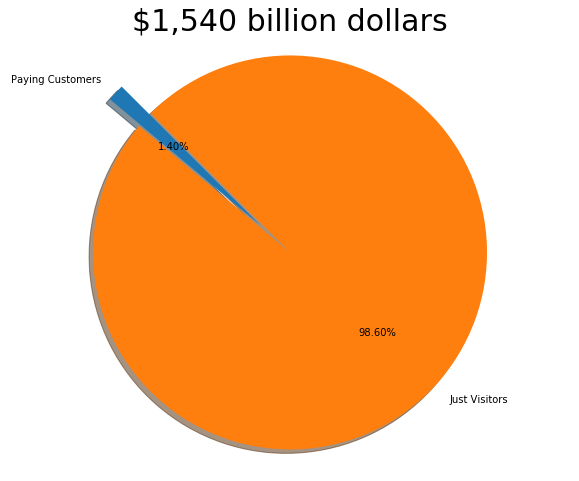

In [114]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype('float')
df_visitor_revenue = df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 8))
labels = ['Paying Customers', 'Just Visitors']
num_of_customers = np.sum(df_visitor_revenue['totals.transactionRevenue'] > 0)
sizes = [num_of_customers, len(df_visitor_revenue) - num_of_customers]
explode = (0.2, 0.0)
ax.pie(sizes, explode=explode, labels=labels, autopct='%.2f%%', shadow=True, startangle=-225)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('${:,.0f} billion dollars'.format(df_train['totals.transactionRevenue'].sum() / 1000000000.00),
             fontdict={'fontsize': 30})
plt.show()

In [175]:
target = 'totals.transactionRevenue'

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
y_train = kmeans.fit_predict(np.array(df_train[target]).reshape(-1, 1))
pd.Series(data=y_train).value_counts()

0    903171
2       476
1         6
dtype: int64

In [177]:
from imblearn.combine import SMOTEENN

smenn = SMOTEENN(sampling_strategy='not majority')
X_train, y = smenn.fit_sample(df_train, y_train)

In [179]:
pd.Series(data=y).value_counts()

1    862441
0    794380
2    707313
dtype: int64

In [121]:
visitor = ['date', 'fullVisitorId', 'visitStartTime']

df_visitor = df_train.groupby(visitor)

In [122]:
df_visitor[['totals.transactionRevenue']].sum().sort_values('date', ascending=False)

totals.transactionRevenue
date       fullVisitorId       visitStartTime                                
2017-08-01 9997536057704001970 2017-08-01 22:24:30                        0.0
           3185267375068033750 2017-08-01 18:20:48                        0.0
           3223204375135993191 2017-08-01 11:00:59                        0.0
           3216630563520692965 2017-08-01 13:53:40                        0.0
           3216248927128711205 2017-08-02 02:52:01                        0.0
                               2017-08-01 17:08:43                        0.0
           3202702203880218774 2017-08-01 16:13:52                        0.0
           3188213086470041425 2017-08-01 22:09:19                        0.0
           3185340328434384553 2017-08-02 01:05:05                        0.0
           3180401077302779113 2017-08-01 20:04:56                        0.0
           3225678380873744420 2017-08-01 18:46:07                        0.0
           3169570421590598903 2017-08-01 15:55:03                        0.0
           3165222879949298835 2017-08-01 17:47:06                        0.0
                               2017-08-01 17:42:14                        0.0
           3163445913479822404 2017-08-01 23:43:34                        0.0
                               2017-08-01 19:06:30                        0.0
           3156290731347491246 2017-08-01 13:19:02                        0.0
           3154127406818956704 2017-08-01 19:16:32                        0.0
           3224554362885235073 2017-08-02 06:04:12                        0.0
           3239591421883808376 2017-08-01 23:10:34                        0.0
           3144514026711253313 2017-08-02 01:45:15                        0.0
           3254275360019244091 2017-08-01 18:37:44                        0.0
           3289637780548369455 2017-08-01 13:25:09                        0.0
           3289130508268605958 2017-08-02 06:38:44                        0.0
           3288761792927926647 2017-08-02 06:59:21                        0.0
           328471737114294646  2017-08-02 01:29:46                        0.0
           327045608747831321  2017-08-01 12:15:45                        0.0
           3268116023206748983 2017-08-01 14:51:20                        0.0
           3266194162388572893 2017-08-01 14:58:24                        0.0
           3253346348290773437 2017-08-02 06:30:38                        0.0
...                                                                       ...
2016-08-01 6255503582981118208 2016-08-01 14:45:35                        0.0
           6256902362089067902 2016-08-02 00:33:05                        0.0
           6257871557133780030 2016-08-01 21:14:32                        0.0
           6091498163535424271 2016-08-01 22:51:01                        0.0
           6068822397105790135 2016-08-01 22:48:25                        0.0
           6062692528026913835 2016-08-01 23:14:07                        0.0
           5971777881107526146 2016-08-02 05:50:15                        0.0
           5893678746287429244 2016-08-01 09:54:36                        0.0
           5916967136802979782 2016-08-02 01:22:53                        0.0
           5923605856827327918 2016-08-01 22:17:21                        0.0
                               2016-08-01 22:18:48                        0.0
           5946672336805397304 2016-08-01 18:07:38                        0.0
                               2016-08-01 18:56:02                        0.0
                               2016-08-01 20:36:00                        0.0
           5957423750259408181 2016-08-02 04:43:07                        0.0
           5961761097538346074 2016-08-02 04:48:20                        0.0
           5963471621704219473 2016-08-01 20:07:14                        0.0
           5990026038672153765 2016-08-02 05:29:14                        0.0
           6052333928516105307 2016-08-02 00:23:53                        

In [123]:
channel = ['channelGrouping']
df_channel = df_train.groupby(channel)

In [124]:
df_channel[['totals.transactionRevenue']].sum().sort_values('totals.transactionRevenue', ascending=False)

totals.transactionRevenue
channelGrouping                           
Referral                      6.514299e+11
Direct                        4.348406e+11
Organic Search                3.263805e+11
Display                       7.833746e+10
Paid Search                   4.355890e+10
Social                        4.916540e+09
Affiliates                    5.973800e+08
(Other)                       9.990000e+06

In [125]:
df_channel['fullVisitorId'].describe()

count  unique                  top  freq
channelGrouping                                           
(Other)             120      95  4927574031144324120     4
Affiliates        16403   13545  6831831775310617658    38
Direct           143026  111440  3269834865385146569   152
Display            6262    4197  1957458976293878100    89
Organic Search   381561  315400   824839726118485274   243
Paid Search       25326   18993  3608475193341679870   118
Referral         104838   67844  7634897085866546110   104
Social           226117  213184   720311197761340948   141

In [126]:
trafficSource = ['channelGrouping',
                 'trafficSource.medium',
                 'trafficSource.source']

df_trafficSource = df_train.groupby(trafficSource)

In [127]:
df_trafficSource[['totals.transactionRevenue']].sum().sort_values('totals.transactionRevenue', ascending=False)

totals.transactionRevenue
channelGrouping trafficSource.medium trafficSource.source                                          
Referral        referral             mall.googleplex.com                               6.129680e+11
Direct          none                 (direct)                                          4.348406e+11
Organic Search  organic              google                                            3.239874e+11
Display         cpm                  dfa                                               7.692842e+10
Paid Search     cpc                  google                                            4.355890e+10
Referral        referral             mail.google.com                                   2.332791e+10
                                     dealspotr.com                                     5.690640e+09
                                     sites.google.com                                  4.390780e+09
                                     gdeals.googleplex.com                             2.175540e+09
Social          referral             groups.google.com                                 1.631260e+09
Display         cpm                  google                                            1.409040e+09
Organic Search  organic              yahoo                                             1.374960e+09
Social          referral             facebook.com                                      1.137670e+09
                                     l.facebook.com                                    1.043720e+09
Organic Search  organic              bing                                              9.877200e+08
Affiliates      affiliate            Partners                                          5.973800e+08
Referral        referral             connect.googleforwork.com                         4.048100e+08
                                     mg.mail.yahoo.com                                 3.773100e+08
                                     siliconvalley.about.com                           3.772200e+08
                                     google.com                                        3.472400e+08
Social          referral             youtube.com                                       3.140700e+08
Referral        referral             phandroid.com                                     2.717400e+08
Social          referral             t.co                                              2.676800e+08
                                     plus.google.com                                   2.054300e+08
Referral        referral             googleux.perksplus.com                            2.033300e+08
Social          referral             m.facebook.com                                    1.868000e+08
Referral        referral             basecamp.com                                      1.058000e+08
                                     search.myway.com                                  1.009400e+08
Social          referral             pinterest.com                                     9.596000e+07
Referral        referral             duckduckgo.com                                    8.407000e+07
...                                                                                             ...
                                     cases2.corp.google.com                            0.000000e+00
                                     cases.corp.google.com                             0.000000e+00
                                     ca.search.yahoo.com                               0.000000e+00
                                     businessinsider.in                                0.000000e+00
                                     businessinsider.com                               0.000000e+00
                                     brewmaster.corp.google.com                        0.000000e+00
                                     datastudio.google.com                             0.000000e+00
                                     dena-design.qiita.com                

In [128]:
df_trafficSource['fullVisitorId'].describe()

count  \
channelGrouping trafficSource.medium trafficSource.source                                         
(Other)         unknown              Partners                                                 8   
                                     google                                                  41   
                                     none                                                    69   
                                     yahoo                                                    2   
Affiliates      affiliate            Partners                                             16403   
Direct          none                 (direct)                                            143026   
Display         cpm                  (direct)                                                 2   
                                     dfa                                                   5686   
                                     google                                                 574   
Organic Search  organic              aol                                                     11   
                                     ask                                                    270   
                                     baidu                                                 3356   
                                     bing                                                  1529   
                                     centrum.cz                                               3   
                                     go.mail.ru                                               5   
                                     google                                              374848   
                                     images.google                                           49   
                                     msn                                                      1   
                                     so.com                                                   8   
                                     yahoo                                                 1478   
                                     yandex                                                   3   
Paid Search     cpc                  bing                                                     1   
                                     google                                               25325   
Referral        referral             0.muppet1.frontend.gws.muppet-exp.ij-q.borg.goo...       1   
                                     0.shared.bow.cat2.ads-bow.lf.borg.google.com:9817        1   
                                     0.shared.bow.cat2.ads-bow.lf.borg.google.com:9824        1   
                                     0.shared.bow.cat2.ads-bow.lf.borg.google.com:9857        1   
                                     0.shared.bow.cat2.ads-bow.lf.borg.google.com:9860        1   
                                     0.shared.bow.cat2.ads-bow.lf.borg.google.com:9879        1   
                                     0.shared.bow.cat2.ads-bow.lf.borg.google.com:9898        2   
...                                                                                         ...   
Social          referral             facebook.com                                          2296   
                                     getpocket.com                                           17   
                                     groups.google.com                                     1025   
                                     it.pinterest.com                                         1   
                                     kr.pinterest.com                                         3   
                                     l.facebook.com                                         795   
                                     linkedin.com                                            23   
                                     lm.facebook.com                                         56   
                               

In [129]:
ads = ['trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.campaign',
       'channelGrouping',
       'trafficSource.adContent',
       'trafficSource.keyword']

df_ads = df_train.groupby(ads)[['totals.transactionRevenue']].sum()
df_ads.loc[df_ads['totals.transactionRevenue'] >= 0] \
      .sort_values('totals.transactionRevenue', ascending=False)

totals.transactionRevenue
trafficSource.adwordsClickInfo.adNetworkType trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot trafficSource.campaign             channelGrouping trafficSource.adContent         trafficSource.keyword                                 
Google Search                                1.0                                 Top                                 AW - Dynamic Search Ads Whole Site Paid Search     unknown                         6qEhsCssdK0z36ri                          2.256304e+10
                                                                                                                     AW - Accessories                   Paid Search     Google Merchandise Collection   Google Merchandise                        8.073070e+09
                                                                                                                                                                                                        google merchandise store                  5.479890e+09
                                                                                                                     AW - Dynamic Search Ads Whole Site Paid Search     unknown                         1hZbAqLCbjwfgOH7                          3.823750e+09
                                                                                                                     AW - Accessories                   Paid Search     Google Merchandise Collection   +Google +Merchandise                      1.026330e+09
                                                                                 RHS                                 AW - Dynamic Search Ads Whole Site Paid Search     unknown                         6qEhsCssdK0z36ri                          4.198600e+08
                                                                                 Top                                 AW - Dynamic Search Ads Whole Site Paid Search     unknown                         1X4Me6ZKNV0zg-jV                          3.089100e+08
                                                                                                                     AW - Accessories                   Paid Search     {KeyWord:Google Branded Gear}   +Google +Gear                             2.242400e+08
                                                                                                                                                                        Google Merchandise Collection   +google +merchandise +store               2.228400e+08
                                                                                                                                                                        Google Online Store             google store                              9.597000e+07
                                                                                                                     AW - Apparel                       Paid Search     {KeyWord:Google Men's T-Shirts} +google+tshirts                           7.782000e+07
                                                                                                                     AW - Accessories                   Paid Search     Google Merchandise Collection   +google +merch                            7.499000e+07
                                                                                                                                                                        Google Online Store             +google +store                            5.046000e+07
                                                                                                                                                                        Swag with Google Logos          +Google +Swag                             3.446000e+07
                                                                                                                                                     

In [130]:
geoNetwork = ['geoNetwork.continent', 'geoNetwork.subContinent',
              'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.city',
              'geoNetwork.metro', 'geoNetwork.networkDomain', 'channelGrouping']

df_geonetwork = df_train.groupby(geoNetwork)[['totals.transactionRevenue']].sum()
df_geonetwork.loc[df_geonetwork['totals.transactionRevenue'] >= 0] \
             .sort_values('totals.transactionRevenue', ascending=False)

totals.transactionRevenue
geoNetwork.continent geoNetwork.subContinent geoNetwork.country geoNetwork.region geoNetwork.city geoNetwork.metro                  geoNetwork.networkDomain      channelGrouping                           
Americas             Northern America        United States      New York          New York        New York NY                       unknown                       Referral                      1.126886e+11
                                                                unknown           unknown         unknown                           unknown                       Referral                      9.549600e+10
                                                                                                                                                                  Direct                        6.612258e+10
                                                                California        Mountain View   San Francisco-Oakland-San Jose CA unknown                       Referral                      6.285658e+10
                                                                unknown           unknown         unknown                           comcastbusiness.net           Display                       5.927312e+10
                                                                California        San Francisco   San Francisco-Oakland-San Jose CA unknown                       Referral                      5.174772e+10
                                                                unknown           unknown         unknown                           comcastbusiness.net           Direct                        4.918636e+10
                                                                                                                                    unknown                       Organic Search                4.868666e+10
                                                                New York          New York        New York NY                       unknown                       Direct                        3.162659e+10
                                                                Illinois          Chicago         Chicago IL                        unknown                       Referral                      2.840950e+10
                                                                unknown           unknown         unknown                           comcast.net                   Direct                        2.393162e+10
                                                                California        Mountain View   San Francisco-Oakland-San Jose CA comcast.net                   Referral                      2.125785e+10
                                                                Michigan          Ann Arbor       Detroit MI                        unknown                       Referral                      2.083916e+10
                                                                New York          New York        New York NY                       unknown                       Organic Search                2.020480e+10
                                                                Virginia          Salem           Roanoke-Lynchburg VA              comcastbusiness.net           Direct                        1.916710e+10
                                                                unknown           unknown         unknown                           comcast.net                   Organic Search                1.604547e+10
                                                                California        Sunnyvale       San Francisco-Oakland-San Jose CA unknown                       Referral                      1.534412e+10
                                                                Illinois          Chicago         Chicago IL                        unknown                       Direct                        1.465774e+10
                                                                California     

In [131]:
device = ['device.deviceCategory', 'device.browser', 'device.operatingSystem', 'channelGrouping']

df_device = df_train.groupby(device)[['totals.transactionRevenue']].sum()
df_device.loc[df_device['totals.transactionRevenue'] >= 0] \
         .sort_values('totals.transactionRevenue', ascending=False)

totals.transactionRevenue
device.deviceCategory device.browser    device.operatingSystem channelGrouping                           
desktop               Chrome            Macintosh              Referral                      5.080070e+11
                                                               Direct                        1.568453e+11
                                                               Organic Search                1.250719e+11
                                        Windows                Direct                        1.204133e+11
                                                               Organic Search                1.050753e+11
                                        Chrome OS              Direct                        8.740974e+10
                                        Windows                Referral                      6.044849e+10
                      Firefox           Windows                Display                       5.925793e+10
                      Chrome            Chrome OS              Referral                      4.976255e+10
                                                               Organic Search                3.608550e+10
                                        Linux                  Referral                      3.179074e+10
                      Firefox           Windows                Direct                        2.126484e+10
mobile                Chrome            Android                Direct                        1.951996e+10
desktop               Chrome            Macintosh              Display                       1.588610e+10
                      Safari            Macintosh              Organic Search                1.519686e+10
                                                               Direct                        1.193602e+10
                      Chrome            Macintosh              Paid Search                   1.098844e+10
                                        Chrome OS              Paid Search                   9.746580e+09
mobile                Chrome            Android                Organic Search                9.014450e+09
desktop               Chrome            Windows                Paid Search                   7.899160e+09
mobile                Safari            iOS                    Organic Search                7.879190e+09
desktop               Safari            Macintosh              Paid Search                   6.638980e+09
                      Internet Explorer Windows                Organic Search                5.599980e+09
                      Chrome            Linux                  Organic Search                5.401960e+09
                                                               Direct                        4.896870e+09
                      Firefox           Windows                Organic Search                4.636040e+09
                      Edge              Windows                Direct                        4.377730e+09
tablet                Safari            iOS                    Organic Search                4.288250e+09
mobile                Safari            iOS                    Direct                        3.165230e+09
                      Chrome            Android                Paid Search                   3.133040e+09
...                                                                                                   ...
desktop               Safari            iOS                    Organic Search                0.000000e+00
                                                               Referral                      0.000000e+00
                      YaBrowser         Macintosh              Direct                        0.000000e+00
                      Safari            unknown                Social                        0.000000e+00
                      YaBrowser         Macintosh              Affiliates                    0.000000e+00
                                        Linux       

## Non-Numeric Data Processing

In [3]:
df_train['date'] = pd.to_datetime(df_train['date'], errors='coerce')
df_train['visitStartTime'] = pd.to_datetime(df_train['visitStartTime'], errors='coerce')
df_train.info()

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null datetime64[ns]
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null datetime64[ns]
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country     

In [4]:
df_test['date'] = pd.to_datetime(df_test['date'], errors='coerce')
df_test['visitStartTime'] = pd.to_datetime(df_test['visitStartTime'], errors='coerce')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 33 columns):
channelGrouping                                 804684 non-null object
date                                            804684 non-null datetime64[ns]
fullVisitorId                                   804684 non-null object
sessionId                                       804684 non-null object
visitId                                         804684 non-null int64
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null datetime64[ns]
device.browser                                  804684 non-null object
device.deviceCategory                           804684 non-null object
device.operatingSystem                          804684 non-null object
geoNetwork.city                                 804684 non-null object
geoNetwork.continent                            804684 non-null object
geoNetwork.country     

In [102]:
df_train.head()

channelGrouping       date        fullVisitorId  \
0          Direct 2016-08-01   423043652415339154   
1          Social 2016-08-01  8294721032567046680   
2  Organic Search 2016-08-01  7718623669497357235   
3  Organic Search 2016-08-01  4798058133221713505   
4          Direct 2016-08-01  5076747981380011349   

                        sessionId     visitId  visitNumber  \
0  0423043652415339154_1470034812  1470034812            3   
1  8294721032567046680_1470035066  1470035066            1   
2  7718623669497357235_1470035081  1470035081            1   
3  4798058133221713505_1470035161  1470035161            1   
4  5076747981380011349_1470035170  1470035170            1   

       visitStartTime device.browser device.deviceCategory  \
0 2016-08-01 07:00:12         Safari                mobile   
1 2016-08-01 07:04:26         Chrome               desktop   
2 2016-08-01 07:04:41    Amazon Silk                tablet   
3 2016-08-01 07:06:01         Chrome               desktop   
4 2016-08-01 07:06:10         Chrome               desktop   

  device.operatingSystem          ...           \
0                    iOS          ...            
1                Windows          ...            
2                Android          ...            
3                Windows          ...            
4                Windows          ...            

  trafficSource.adwordsClickInfo.gclId  \
0                                 none   
1                                 none   
2                                 none   
3                                 none   
4                                 none   

  trafficSource.adwordsClickInfo.isVideoAd  \
0                           Not Applicable   
1                           Not Applicable   
2                           Not Applicable   
3                           Not Applicable   
4                           Not Applicable   

  trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                 0.0                                none   
1                                 0.0                                none   
2                                 0.0                                none   
3                                 0.0                                none   
4                                 0.0                                none   

  trafficSource.campaign trafficSource.isTrueDirect trafficSource.keyword  \
0                unknown                        Yes                  none   
1                unknown             Not Applicable                  none   
2                unknown             Not Applicable                  none   
3                unknown             Not Applicable                  none   
4                unknown                        Yes                  none   

   trafficSource.medium  trafficSource.referralPath  trafficSource.source  
0                  none                        none              (direct)  
1              referral                  /yt/about/           youtube.com  
2               organic                        none                google  
3               organic                        none                google  
4                  none                        none              (direct)  

[5 rows x 34 columns]

In [103]:
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        print(col, '\t\t\t', len(df_train[col].unique()))

channelGrouping 			 8
fullVisitorId 			 720639
sessionId 			 902755
device.browser 			 54
device.deviceCategory 			 3
device.operatingSystem 			 20
geoNetwork.city 			 648
geoNetwork.continent 			 6
geoNetwork.country 			 222
geoNetwork.metro 			 93
geoNetwork.networkDomain 			 28031
geoNetwork.region 			 375
geoNetwork.subContinent 			 23
trafficSource.adContent 			 46
trafficSource.adwordsClickInfo.adNetworkType 			 4
trafficSource.adwordsClickInfo.gclId 			 17776
trafficSource.adwordsClickInfo.isVideoAd 			 3
trafficSource.adwordsClickInfo.slot 			 4
trafficSource.campaign 			 10
trafficSource.isTrueDirect 			 3
trafficSource.keyword 			 3659
trafficSource.medium 			 7
trafficSource.referralPath 			 1476
trafficSource.source 			 380


### Date Encoding

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                       

### Text Encoding
- channelGrouping 8
- fullVisitorId 723803
- sessionId 902755
- device.browser 54
- device.deviceCategory 3
- device.operatingSystem 20
- geoNetwork.continent 6
- geoNetwork.subContinent 23
- geoNetwork.country 222
- geoNetwork.city 648
- geoNetwork.region 375
- geoNetwork.metro 93
- geoNetwork.networkDomain 28064
- trafficSource.adwordsClickInfo.gclId 17776
- trafficSource.adwordsClickInfo.isVideoAd 3
- trafficSource.isTrueDirect 3
- trafficSource.adwordsClickInfo.adNetworkType 4
- trafficSource.adwordsClickInfo.slot 4
- trafficSource.medium 7
- trafficSource.source 380

In [37]:
label_cols_to_encode = ['channelGrouping', 'fullVisitorId', 'sessionId', 
                          'device.browser', 'device.deviceCategory', 'device.operatingSystem',
                          'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 
                          'geoNetwork.city', 'geoNetwork.region', 'geoNetwork.metro', 
                          'geoNetwork.networkDomain', 'trafficSource.adwordsClickInfo.gclId', 
                          'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect', 
                          'trafficSource.adwordsClickInfo.adNetworkType', 
                          'trafficSource.adwordsClickInfo.slot', 'trafficSource.medium', 
                          'trafficSource.source']

In [38]:
from sklearn.preprocessing import LabelEncoder

encoders = dict()
for c in label_cols_to_encode:
    if (df_train[c].dtypes == 'object'):
        encoders[c] = LabelEncoder()
        encoders[c].fit(pd.concat([df_train[c], df_test[c]], axis=0).astype(str))
        df_train[c] = encoders[c].transform(df_train[c].astype(str))
        df_test[c] = encoders[c].transform(df_test[c].astype(str))
encoders

{'channelGrouping': LabelEncoder(),
 'fullVisitorId': LabelEncoder(),
 'sessionId': LabelEncoder(),
 'device.browser': LabelEncoder(),
 'device.deviceCategory': LabelEncoder(),
 'device.operatingSystem': LabelEncoder(),
 'geoNetwork.continent': LabelEncoder(),
 'geoNetwork.subContinent': LabelEncoder(),
 'geoNetwork.country': LabelEncoder(),
 'geoNetwork.city': LabelEncoder(),
 'geoNetwork.region': LabelEncoder(),
 'geoNetwork.metro': LabelEncoder(),
 'geoNetwork.networkDomain': LabelEncoder(),
 'trafficSource.adwordsClickInfo.gclId': LabelEncoder(),
 'trafficSource.adwordsClickInfo.isVideoAd': LabelEncoder(),
 'trafficSource.isTrueDirect': LabelEncoder(),
 'trafficSource.adwordsClickInfo.adNetworkType': LabelEncoder(),
 'trafficSource.adwordsClickInfo.slot': LabelEncoder(),
 'trafficSource.medium': LabelEncoder(),
 'trafficSource.source': LabelEncoder()}

In [39]:
import pickle as pk

# Save LabelEncoders
pk.dump(encoders, open(prefix + 'handles/encoders.pk', 'wb'))

In [40]:
# inspect the encoded classes
for k, v in encoders.items():
    df_unique = np.sort(df_train[k].unique())
    print(k, df_train[k].shape[0], 
          df_unique, v.classes_.shape[0], 
          v.inverse_transform(df_unique))

channelGrouping 903653 [0 1 2 3 4 5 6 7] 8 ['(Other)' 'Affiliates' 'Direct' 'Display' 'Organic Search' 'Paid Search'
 'Referral' 'Social']
fullVisitorId 903653 [      9      24      25 ... 1325364 1325365 1325367] 1325370 ['0001963576650517672' '0005012088711421541' '0005224157940049074' ...
 '999997550040396460' '9999978264901065827' '9999986437109498564']
sessionId 903653 [      2       3       4 ... 1706607 1706608 1706611] 1706613 ['0000010278554503158_1477029466' '0000020424342248747_1480578901'
 '0000027376579751715_1486866293' ... '999997550040396460_1492640838'
 '9999978264901065827_1485325580' '9999986437109498564_1491867670']
device.browser 903653 [  1  22  23  25  26  27  28  30  32  33  34  35  36  40  41  42  43  44
  45  46  47  49  50  51  52  53  54  55  56  57  58  60  61  62  64  65
  66  68  69  71  72  74  75  76  77  78  79  80  81  82 109 112 116 120] 129 ['0' 'ADM' 'Amazon Silk' 'Android Browser' 'Android Runtime'
 'Android Webview' 'Apple-iPhone7C2' 'BlackBerry'

In [17]:
# inspect the encoded classes
for k, v in encoders.items():
    df_unique = np.sort(df_test[k].unique())
    print(k, df_test[k].shape[0], 
          df_unique, v.classes_.shape[0], 
          v.inverse_transform(df_unique))

channelGrouping 804684 [0 1 2 3 4 5 6 7] 8 ['(Other)' 'Affiliates' 'Direct' 'Display' 'Organic Search' 'Paid Search'
 'Referral' 'Social']
fullVisitorId 804684 [      0       1       2 ... 1325366 1325368 1325369] 1325370 ['0000053049821714864' '0000150005271820273' '0000354865008116989' ...
 '9999985820452794361' '99999951882718968' '9999997304197521748']
sessionId 804684 [      0       1       8 ... 1706609 1706610 1706612] 1706613 ['0000000259678714014_1511912001' '0000000259678714014_1511914780'
 '0000049363351866189_1505779414' ... '9999985820452794361_1524173872'
 '9999985820452794361_1524174443' '9999997304197521748_1508004130']
device.browser 804684 [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  27  28  29  30  31  32  34  35  37  38  39  41
  42  46  47  48  49  52  54  55  56  57  58  59  61  62  63  65  66  67
  68  70  71  72  73  74  75  78  80  81  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 1

In [41]:
datetime_cols_to_encode = ['date', 'visitStartTime']

In [42]:
import time

for col in datetime_cols_to_encode:
    df_train[col] = df_train[col].astype('int64', copy=False)
    df_test[col] = df_test[col].astype('int64', copy=False)

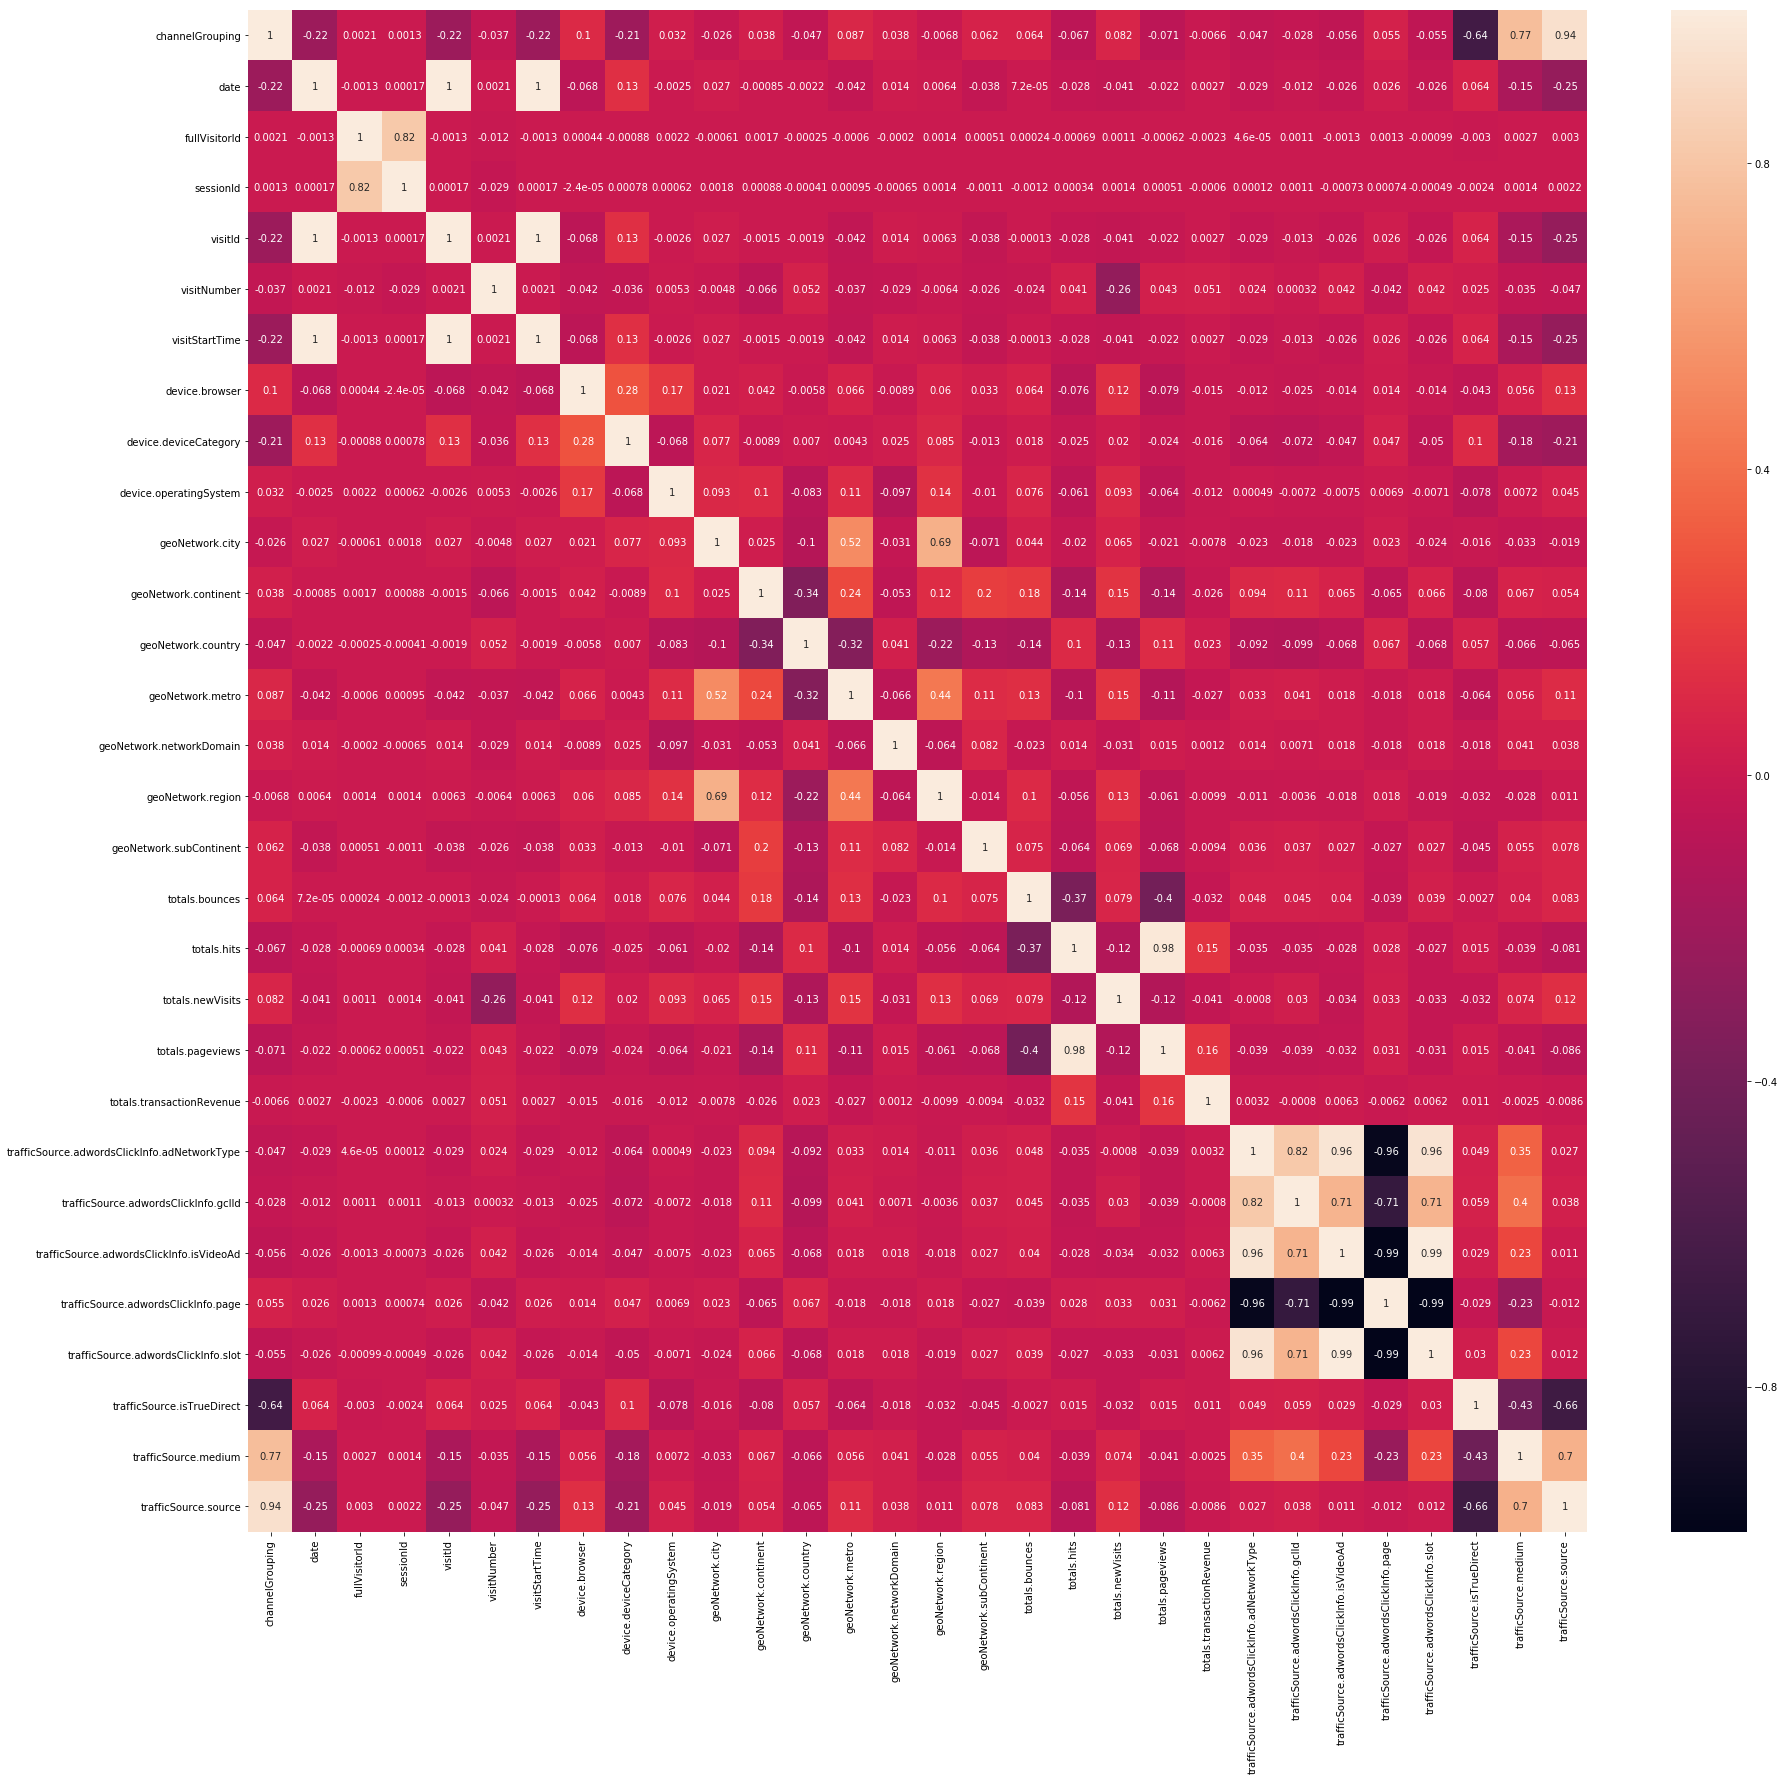

In [102]:
fig, ax = plt.subplots(figsize=(30, 28))
sns.heatmap(df_train.corr(), annot=True, ax=ax)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


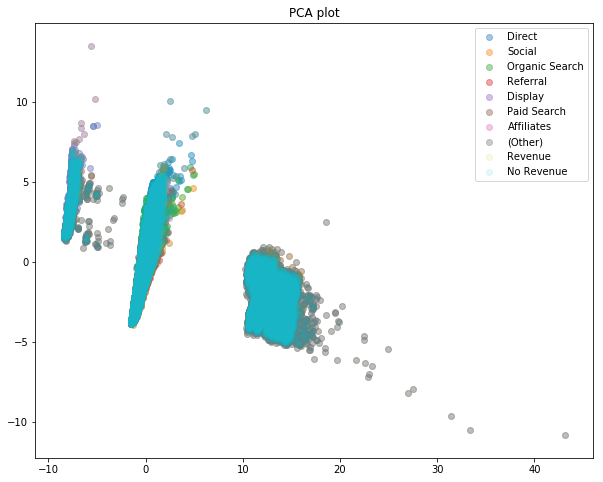

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

# scaling dataset just to explore for PCA
X = scaler.fit_transform(df_train)

import pickle as pk

# Save LabelEncoders
encoders = pk.load(open(prefix + 'handles/encoders.pk', 'rb'))

# fit dataset to PCA of 2 components and plot
# coloured based on (M or 1 = malignant, B or 0 = benign)
pca = PCA(n_components=2) 
Z_2d = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 8))

# row_selector y==0 (selects all rows where y==0)
# col_selector 0 (selects the 1st column / component)
# Z_2d[y==0, 0]
# plotting 1st vs. 2nd PCA component

labels = df_train['channelGrouping'].unique()

for l in labels:
    ax.scatter(Z_2d[df_train['channelGrouping'] == l, 0], 
               Z_2d[df_train['channelGrouping'] == l, 1], 
               label=encoders['channelGrouping'].inverse_transform([l])[0],
               alpha=0.4)

ax.scatter(Z_2d[df_train['totals.transactionRevenue'] > 0, 0], 
           Z_2d[df_train['totals.transactionRevenue'] > 0, 1], 
           label='Revenue', alpha=0.1)
ax.scatter(Z_2d[df_train['totals.transactionRevenue'] <= 0, 0], 
           Z_2d[df_train['totals.transactionRevenue'] <= 0, 1], 
           label='No Revenue', alpha=0.1)
    
ax.set(title='PCA plot')
ax.legend()

## Modeling (without text)

In [3]:
target = 'totals.transactionRevenue'

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
channelGrouping                                 903653 non-null int64
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null int64
sessionId                                       903653 non-null int64
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null int64
device.deviceCategory                           903653 non-null int64
device.operatingSystem                          903653 non-null int64
geoNetwork.city                                 903653 non-null int64
geoNetwork.continent                            903653 non-null int64
geoNetwork.country                              9

In [16]:
categorical_features = ['channelGrouping', 'device.browser', 'device.deviceCategory', 
                        'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 
                        'geoNetwork.metro', 'geoNetwork.region', 'geoNetwork.subContinent', 
                        'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 
                        'trafficSource.isTrueDirect', 'trafficSource.medium', 'trafficSource.source']

In [17]:
other_cols = []

for col in df_train.columns:
    if not col in categorical_features and col != target:
        other_cols.append(col)
print('Train', train_other_cols)

Train ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'geoNetwork.networkDomain', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot']


In [18]:
columns=[target] + other_cols + categorical_features
X_train = np.hstack((df_train.loc[:, target].values.reshape(-1, 1),
                     df_train.loc[:, other_cols].values,
                     df_train.loc[:, categorical_features].values))
X_train = pd.DataFrame(data=X_train, columns=columns)
X_train.shape

(903653, 30)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
totals.transactionRevenue                       903653 non-null float64
date                                            903653 non-null float64
fullVisitorId                                   903653 non-null float64
sessionId                                       903653 non-null float64
visitId                                         903653 non-null float64
visitNumber                                     903653 non-null float64
visitStartTime                                  903653 non-null float64
geoNetwork.networkDomain                        903653 non-null float64
totals.bounces                                  903653 non-null float64
totals.hits                                     903653 non-null float64
totals.newVisits                                903653 non-null float64
totals.pageviews                                903653 non-null float64
trafficSource.adwordsClic

In [20]:
y = X_train.loc[:, target].values.reshape(-1, 1)
y.shape

(903653, 1)

In [21]:
print('Running K means ...')
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_jobs=cpu_threads, algorithm='full', tol=1e-5)
classes = kmeans.fit_predict(y)
class_stats = pd.Series(data=classes).value_counts()
print(class_stats)

Running K means ...
0    903180
2       467
1         6
dtype: int64


In [22]:
smallest_class = class_stats.idxmin()

if class_stats[smallest_class] < 24:
    print('Duplicating x5 records of smallest class group in each dataset')
    mask = (classes == smallest_class)
    class_set = classes[mask]
    for _ in range(3):
        class_set = np.concatenate((class_set, classes[mask]))    
    classes = np.concatenate((classes, class_set), axis=0)

    class_set = X_train[mask]
    for _ in range(3):
        class_set = pd.concat((class_set, X_train[mask]), axis=0)
    X_train = pd.concat((X_train, class_set), axis=0)

    print(pd.Series(data=classes).value_counts())
X_train.shape

Duplicating x5 records of smallest class group in each dataset
0    903180
2       467
1        30
dtype: int64


(903677, 30)

In [23]:
from sklearn.model_selection import train_test_split

datasets = [[[], [], [], []], 
            [[], [], [], []],
            [[], [], [], []],
            [[], [], [], []]]

datasets[0][0], datasets[1][0], datasets[0][1], datasets[1][1] = train_test_split(X_train, classes, 
                                                                                  stratify=classes,
                                                                                  shuffle=True, train_size=.25)

datasets[1][0], datasets[2][0], datasets[1][1], datasets[2][1] = train_test_split(datasets[1][0], datasets[1][1], 
                                                                                  stratify=datasets[1][1],
                                                                                  shuffle=True, train_size=0.33)

datasets[2][0], datasets[3][0], datasets[2][1], datasets[3][1] = train_test_split(datasets[2][0], datasets[2][1], 
                                                                                  stratify=datasets[2][1],
                                                                                  shuffle=True, train_size=0.50)

print('Dataset 1:', datasets[0][0].shape)
print(pd.Series(data=datasets[0][1]).value_counts())
print('')

print('Dataset 2:', datasets[1][0].shape)
print(pd.Series(data=datasets[1][1]).value_counts())
print('')

print('Dataset 3:', datasets[2][0].shape)
print(pd.Series(data=datasets[2][1]).value_counts())
print('')

print('Dataset 4:', datasets[3][0].shape)
print(pd.Series(data=datasets[3][1]).value_counts())
print('')


c:\program files\python\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
c:\program files\python\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
c:\program files\python\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Dataset 1: (225919, 30)
0    225795
2       117
1         7
dtype: int64

Dataset 2: (223660, 30)
0    223537
2       115
1         8
dtype: int64

Dataset 3: (227049, 30)
0    226924
2       117
1         8
dtype: int64

Dataset 4: (227049, 30)
0    226924
2       118
1         7
dtype: int64



In [24]:
from imblearn.combine import SMOTEENN

for idx in range(len(datasets)):
    smenn = SMOTEENN(sampling_strategy='not majority')
    datasets[idx][0], datasets[idx][1] = smenn.fit_sample(datasets[idx][0], datasets[idx][1])
    print('Dataset {0}:'.format(idx + 1))
    print(datasets[idx][1].shape)
    print(pd.Series(data=datasets[idx][1]).value_counts())
    print('')

Dataset 1:
(610983,)
0    219104
1    200830
2    191049
dtype: int64

Dataset 2:
(612198,)
0    217098
1    202850
2    192250
dtype: int64

Dataset 3:
(631572,)
0    220592
1    210055
2    200925
dtype: int64

Dataset 4:
(645447,)
0    220443
1    217982
2    207022
dtype: int64



In [26]:
import h5py

dt = h5py.special_dtype(vlen=str)
other_cols_dt = [x.encode('utf-8') for x in other_cols]
categorical_features_dt = [x.encode('utf-8') for x in categorical_features]
target_dt = target.encode('utf-8')

In [27]:
import h5py

for idx in range(len(datasets)):
    print('Saving Dataset {0}...'.format(idx + 1))
    X = pd.DataFrame(data=datasets[idx][0], columns=columns)
    
    with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'w') as hdf5:
        hdf5.create_dataset('Normalized Columns', data=other_cols_dt, dtype=dt)
        hdf5.create_dataset('Categorical Features', data=categorical_features_dt, dtype=dt)
        hdf5.create_dataset('Target', data=[target_dt], dtype=dt)
        hdf5.create_dataset('X_to_normalized', data=X.loc[:, other_cols])
        hdf5.create_dataset('X_categorical_features', data=X.loc[:, categorical_features])
        hdf5.create_dataset('y', data=X.loc[:, target])
        hdf5.create_dataset('train_classes', data=datasets[idx][1])

Saving Dataset 1...
Saving Dataset 2...
Saving Dataset 3...
Saving Dataset 4...


### Loading saved dataset for training

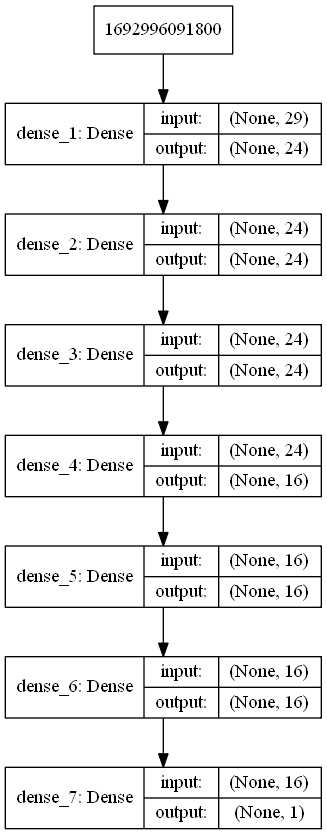

In [15]:
from IPython.display import Image
Image(filename=directory + 'architecture.png')

#### Train: Dataset 1, Validate: Dataset 2

In [3]:
import h5py

idx = 0
with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'r') as hdf5:
    to_normalize_cols = hdf5['Normalized Columns'][:]
    to_normalize_cols = [x.encode().decode('UTF-8') for x in to_normalize_cols]
    
    categorical_features = hdf5['Categorical Features'][:]
    categorical_features = [x.encode().decode('UTF-8') for x in categorical_features]
    
    X_to_normalized = hdf5['X_to_normalized'][:]
    X_categorical_features = hdf5['X_categorical_features'][:]
    y = hdf5['y'][:]
    
import h5py

idx = 1
with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'r') as hdf5:
    X_val_to_normalized = hdf5['X_to_normalized'][:]
    X_val_categorical_features = hdf5['X_categorical_features'][:]
    y_val = hdf5['y'][:]

In [4]:
print('Train:', (y > 0).sum() / len(y) * 100.00)
print('Val:', (y_val > 0).sum() / len(y_val) * 100.00)

Train: 64.58477568115643
Val: 64.96509299278992


In [5]:
print('Train:', (y <= 0).sum() / len(y) * 100.00)
print('Val:', (y_val <= 0).sum() / len(y_val) * 100.00)

Train: 35.41522431884357
Val: 35.03490700721009


In [6]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(copy=False, feature_range=(0, 1))
X_to_normalized = X_scaler.fit_transform(X_to_normalized)
X_val_to_normalized = X_scaler.transform(X_val_to_normalized)

In [7]:
X_train = np.hstack((X_to_normalized, X_categorical_features))
X_train = pd.DataFrame(data=X_train, columns=to_normalize_cols + categorical_features)
print('Train:', X_train.shape)

X_val = np.hstack((X_val_to_normalized, X_val_categorical_features))
X_val = pd.DataFrame(data=X_val, columns=to_normalize_cols + categorical_features)
print('Val:', X_val.shape)

Train: (610983, 29)
Val: (612198, 29)


In [10]:
def root_mean_squared_error(y_true, y_pred):
    from keras import backend as K
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def base_model(X_train, decay=0.0):
    from keras.models import Sequential, Model
    from keras.optimizers import Adadelta, Nadam, SGD, Adam
    from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape
    from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
    from keras.backend import int_shape, shape
    
    model = Sequential()
        
    # block 1
    model.add(Dense(24, activation='relu', input_dim=X_train.shape[1]))
    #model.add(Dropout(0.2))

    model.add(Dense(24, activation='relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(24, activation='relu'))
    #model.add(Dropout(0.1))

    # block 2
    model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.1))
              
    model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(1))

    print(model.summary()) 

    #model.compile(loss=root_mean_squared_error, optimizer='Adadelta', metrics=['mae'])

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00004, amsgrad=True)
    #optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True)
    #optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    #optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

    return model

In [11]:
import os
import time

timestamp = int(time.time())

directory = prefix + 'models/mlp_notext/{0}/'.format(timestamp)
if not os.path.exists(directory + 'weights/'):
    os.makedirs(directory + 'weights/')

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

batch_size = 1191

# Tensorboard for learning curve
# Early stopping (to avoid overfitting)
# Model checkpoint (to save model preiodically)
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
#from keras.callbacks import TensorBoard

hist = History()
#early_stop = EarlyStopping(patience=10, monitor='val_mean_squared_logarithmic_error')
#tensorboard = TensorBoard(log_dir='./logs/mlp_word2vec/{}'.format(int(time.time())))
model_checkpt = ModelCheckpoint(directory + 'weights/val_loss-{val_loss:.2f}_at_epoch-{epoch:02d}.h5')

model = base_model(X_train)

#model.fit(X_train[subsample], y_train[subsample],
model.fit(X_train, y,
          epochs=1000, batch_size=batch_size,
          callbacks=[hist, model_checkpt], #, early_stop, tensorboard],
          shuffle=True, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

610983/610983 [==============================] - 3s 5us/step - loss: 44.5216 - val_loss: 41.5350
Epoch 64/1000
610983/610983 [==============================] - 3s 5us/step - loss: 44.5821 - val_loss: 41.4723
Epoch 65/1000
610983/610983 [==============================] - 3s 5us/step - loss: 44.2006 - val_loss: 41.2375
Epoch 66/1000
610983/610983 [==============================] - 3s 5us/step - loss: 44.2076 - val_loss: 41.1654
Epoch 67/1000
610983/610983 [==============================] - 3s 5us/step - loss: 43.9236 - val_loss: 41.0210
Epoch 68/1000
610983/610983 [==============================] - 3s 5us/step - loss: 43.7839 - val_loss: 40.9567
Epoch 69/1000
610983/610983 [==============================] - 3s 5us/step - loss: 43.8684 - val_loss: 40.7231
Epoch 70/1000
610983/610983 [==============================] - 3s 5us/step - loss: 48.9860 - val_loss: 44.8546
Epoch 71/1000
610983/610983 [==============================] - 3s 5us/step - loss: 44.5506 - val_loss: 41.3973
Epoch 72/1000
6

610983/610983 [==============================] - 3s 5us/step - loss: 35.9508 - val_loss: 33.9175
Epoch 210/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.9283 - val_loss: 33.8936
Epoch 211/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.8956 - val_loss: 33.9674
Epoch 212/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.8803 - val_loss: 33.8804
Epoch 213/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.8682 - val_loss: 33.9515
Epoch 214/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.8418 - val_loss: 33.9491
Epoch 215/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.8482 - val_loss: 33.8716
Epoch 216/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.7675 - val_loss: 33.7492
Epoch 217/1000
610983/610983 [==============================] - 3s 5us/step - loss: 35.7525 - val_loss: 33.7984
Epoch 2

610983/610983 [==============================] - 3s 5us/step - loss: 33.4922 - val_loss: 32.6829
Epoch 356/1000
610983/610983 [==============================] - 3s 5us/step - loss: 34.5506 - val_loss: 33.1316
Epoch 357/1000
610983/610983 [==============================] - 3s 5us/step - loss: 33.5407 - val_loss: 32.7694
Epoch 358/1000
610983/610983 [==============================] - 3s 6us/step - loss: 33.4403 - val_loss: 32.7459
Epoch 359/1000
610983/610983 [==============================] - 3s 5us/step - loss: 33.5138 - val_loss: 32.8481
Epoch 360/1000
610983/610983 [==============================] - 3s 5us/step - loss: 33.4227 - val_loss: 32.8575
Epoch 361/1000
610983/610983 [==============================] - 3s 6us/step - loss: 34.1470 - val_loss: 33.8415
Epoch 362/1000
610983/610983 [==============================] - 3s 5us/step - loss: 33.7216 - val_loss: 32.8060
Epoch 363/1000
610983/610983 [==============================] - 3s 5us/step - loss: 33.3988 - val_loss: 32.7730
Epoch 3

610983/610983 [==============================] - 3s 5us/step - loss: 31.9568 - val_loss: 31.9907
Epoch 502/1000
610983/610983 [==============================] - 3s 5us/step - loss: 31.9304 - val_loss: 32.0323
Epoch 503/1000
610983/610983 [==============================] - 3s 5us/step - loss: 31.9122 - val_loss: 32.0052
Epoch 504/1000
610983/610983 [==============================] - 3s 5us/step - loss: 31.8982 - val_loss: 32.0317
Epoch 505/1000
610983/610983 [==============================] - 3s 5us/step - loss: 31.8917 - val_loss: 32.0210
Epoch 506/1000
610983/610983 [==============================] - 3s 5us/step - loss: 31.8858 - val_loss: 31.9760
Epoch 507/1000
610983/610983 [==============================] - 3s 5us/step - loss: 32.8870 - val_loss: 33.4742
Epoch 508/1000
610983/610983 [==============================] - 3s 5us/step - loss: 32.8484 - val_loss: 32.5049
Epoch 509/1000
610983/610983 [==============================] - 3s 5us/step - loss: 32.3108 - val_loss: 32.0122
Epoch 5

610983/610983 [==============================] - 3s 5us/step - loss: 30.7321 - val_loss: 31.0585
Epoch 648/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.7216 - val_loss: 31.0540
Epoch 649/1000
610983/610983 [==============================] - 3s 5us/step - loss: 31.4572 - val_loss: 31.4968
Epoch 650/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.7900 - val_loss: 31.0411
Epoch 651/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.7329 - val_loss: 31.0524
Epoch 652/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.7125 - val_loss: 31.0134
Epoch 653/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.6990 - val_loss: 31.0005
Epoch 654/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.7002 - val_loss: 30.9993
Epoch 655/1000
610983/610983 [==============================] - 3s 5us/step - loss: 30.6824 - val_loss: 30.9995
Epoch 6

610983/610983 [==============================] - 3s 5us/step - loss: 29.7706 - val_loss: 30.7759
Epoch 794/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.7598 - val_loss: 30.5548
Epoch 795/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.6987 - val_loss: 30.5507
Epoch 796/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.6918 - val_loss: 30.5701
Epoch 797/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.6967 - val_loss: 30.5089
Epoch 798/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.6876 - val_loss: 30.5039
Epoch 799/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.6789 - val_loss: 30.5090
Epoch 800/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.7366 - val_loss: 30.5284
Epoch 801/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.6897 - val_loss: 30.5120
Epoch 8

610983/610983 [==============================] - 3s 5us/step - loss: 28.8667 - val_loss: 30.1573
Epoch 940/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.8505 - val_loss: 30.1468
Epoch 941/1000
610983/610983 [==============================] - 3s 5us/step - loss: 29.0487 - val_loss: 30.1465
Epoch 942/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.8354 - val_loss: 30.1607
Epoch 943/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.8110 - val_loss: 30.1786
Epoch 944/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.8044 - val_loss: 30.1326
Epoch 945/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.8728 - val_loss: 30.1710
Epoch 946/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.8725 - val_loss: 30.1099
Epoch 947/1000
610983/610983 [==============================] - 3s 5us/step - loss: 28.7975 - val_loss: 30.0905
Epoch 9

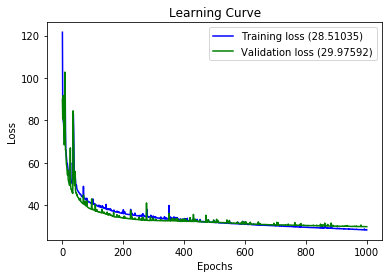

In [14]:
plot_history(hist)

#### Train: Dataset 2, Validate: Dataset 3

In [48]:
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

# Model reconstruction from JSON file
with open(prefix + 'models/mlp_notext/1545027753/architecture.json', 'r') as f:
    model = model_from_json(f.read()) 

print(model.summary())
#model = insert_intermediate_layer_in_keras(model, 1, Dropout(0.05))

from keras.optimizers import Adadelta, Nadam, SGD, Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00004, amsgrad=True)
#optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True)
#optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

# Load trained weights into the model
model.load_weights(prefix + 'models/mlp_notext/1545027753/weights/val_loss-29.96_at_epoch-999.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

In [49]:
import h5py

idx = 1
with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'r') as hdf5:
    to_normalize_cols = hdf5['Normalized Columns'][:]
    to_normalize_cols = [x.encode().decode('UTF-8') for x in to_normalize_cols]
    
    categorical_features = hdf5['Categorical Features'][:]
    categorical_features = [x.encode().decode('UTF-8') for x in categorical_features]
    
    X_to_normalized = hdf5['X_to_normalized'][:]
    X_categorical_features = hdf5['X_categorical_features'][:]
    y = hdf5['y'][:]
    
import h5py

idx = 2
with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'r') as hdf5:
    X_val_to_normalized = hdf5['X_to_normalized'][:]
    X_val_categorical_features = hdf5['X_categorical_features'][:]
    y_val = hdf5['y'][:]

In [50]:
print('Train:', (y > 0).sum() / len(y) * 100.00)
print('Val:', (y_val > 0).sum() / len(y_val) * 100.00)

Train: 64.96509299278992
Val: 65.4900787241993


In [51]:
print('Train:', (y <= 0).sum() / len(y) * 100.00)
print('Val:', (y_val <= 0).sum() / len(y_val) * 100.00)

Train: 35.03490700721009
Val: 34.5099212758007


In [52]:
from sklearn.preprocessing import MinMaxScaler

import pickle as pk

X_scaler = pk.load(open(prefix + 'models/mlp_notext/1545027753/scaler.pk', 'rb'))
X_to_normalized = X_scaler.fit_transform(X_to_normalized)
X_val_to_normalized = X_scaler.transform(X_val_to_normalized)

In [53]:
X_train = np.hstack((X_to_normalized, X_categorical_features))
X_train = pd.DataFrame(data=X_train, columns=to_normalize_cols + categorical_features)
print('Train:', X_train.shape)

X_val = np.hstack((X_val_to_normalized, X_val_categorical_features))
X_val = pd.DataFrame(data=X_val, columns=to_normalize_cols + categorical_features)
print('Val:', X_val.shape)

Train: (612198, 29)
Val: (631572, 29)


In [54]:
import os
import time

timestamp = int(time.time())

directory = prefix + 'models/mlp_notext_1/{0}/'.format(timestamp)
if not os.path.exists(directory + 'weights/'):
    os.makedirs(directory + 'weights/')

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

batch_size = 1191

# Tensorboard for learning curve
# Early stopping (to avoid overfitting)
# Model checkpoint (to save model preiodically)
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
#from keras.callbacks import TensorBoard

hist = History()
#early_stop = EarlyStopping(patience=10, monitor='val_mean_squared_logarithmic_error')
#tensorboard = TensorBoard(log_dir='./logs/mlp_word2vec/{}'.format(int(time.time())))
model_checkpt = ModelCheckpoint(directory + 'weights/val_loss-{val_loss:.2f}_at_epoch-{epoch:02d}.h5')

#model = base_model(X_train)

#model.fit(X_train[subsample], y_train[subsample],
model.fit(X_train, y,
          epochs=1000, batch_size=batch_size,
          callbacks=[hist, model_checkpt], #, early_stop, tensorboard],
          shuffle=True, validation_data=(X_val, y_val))

Train on 612198 samples, validate on 631572 samples
Epoch 1/1000
612198/612198 [==============================] - 4s 7us/step - loss: 30.3590 - val_loss: 31.4904
Epoch 2/1000
612198/612198 [==============================] - 3s 5us/step - loss: 26.7890 - val_loss: 28.1311
Epoch 3/1000
612198/612198 [==============================] - 3s 5us/step - loss: 34.6831 - val_loss: 33.4662
Epoch 4/1000
612198/612198 [==============================] - 3s 5us/step - loss: 26.0872 - val_loss: 30.1413
Epoch 5/1000
612198/612198 [==============================] - 3s 5us/step - loss: 25.6510 - val_loss: 28.4954
Epoch 6/1000
612198/612198 [==============================] - 3s 5us/step - loss: 25.8862 - val_loss: 33.7768
Epoch 7/1000
612198/612198 [==============================] - 3s 5us/step - loss: 27.7670 - val_loss: 29.8301
Epoch 8/1000
612198/612198 [==============================] - 3s 6us/step - loss: 30.6668 - val_loss: 30.8537
Epoch 9/1000
612198/612198 [==============================] - 3s 6us

612198/612198 [==============================] - 3s 6us/step - loss: 19.1522 - val_loss: 27.6311
Epoch 148/1000
612198/612198 [==============================] - 3s 6us/step - loss: 19.1115 - val_loss: 28.4319
Epoch 149/1000
612198/612198 [==============================] - 3s 6us/step - loss: 19.1272 - val_loss: 27.2616
Epoch 150/1000
612198/612198 [==============================] - 3s 6us/step - loss: 19.1435 - val_loss: 26.6024
Epoch 151/1000
612198/612198 [==============================] - 4s 6us/step - loss: 19.0306 - val_loss: 27.8417
Epoch 152/1000
612198/612198 [==============================] - 4s 6us/step - loss: 19.0825 - val_loss: 27.4826
Epoch 153/1000
612198/612198 [==============================] - 3s 6us/step - loss: 19.0597 - val_loss: 28.1698
Epoch 154/1000
612198/612198 [==============================] - 4s 6us/step - loss: 19.0984 - val_loss: 28.4297
Epoch 155/1000
612198/612198 [==============================] - 4s 6us/step - loss: 21.5631 - val_loss: 27.9356
Epoch 1

612198/612198 [==============================] - 3s 6us/step - loss: 16.0441 - val_loss: 22.1399
Epoch 294/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.9497 - val_loss: 24.0698
Epoch 295/1000
612198/612198 [==============================] - 3s 6us/step - loss: 16.0337 - val_loss: 23.2987
Epoch 296/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.8565 - val_loss: 22.9880
Epoch 297/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.8311 - val_loss: 23.1193
Epoch 298/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.8919 - val_loss: 22.9258
Epoch 299/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.8650 - val_loss: 23.8025
Epoch 300/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.7469 - val_loss: 23.3255
Epoch 301/1000
612198/612198 [==============================] - 3s 6us/step - loss: 15.7417 - val_loss: 24.1262
Epoch 3

612198/612198 [==============================] - 3s 6us/step - loss: 14.0514 - val_loss: 23.4497
Epoch 440/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.9952 - val_loss: 23.3724
Epoch 441/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.9899 - val_loss: 23.7577
Epoch 442/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.9834 - val_loss: 23.6613
Epoch 443/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.9702 - val_loss: 23.8889
Epoch 444/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.9762 - val_loss: 24.2065
Epoch 445/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.9721 - val_loss: 24.1506
Epoch 446/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.9709 - val_loss: 24.2699
Epoch 447/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.9624 - val_loss: 24.0339
Epoch 4

612198/612198 [==============================] - 3s 6us/step - loss: 13.2493 - val_loss: 23.2754
Epoch 586/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.1152 - val_loss: 22.3069
Epoch 587/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.0818 - val_loss: 23.9975
Epoch 588/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.0724 - val_loss: 23.7596
Epoch 589/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.0484 - val_loss: 23.8193
Epoch 590/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.0704 - val_loss: 21.4129
Epoch 591/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.1129 - val_loss: 22.5362
Epoch 592/1000
612198/612198 [==============================] - 3s 6us/step - loss: 13.2437 - val_loss: 23.6178
Epoch 593/1000
612198/612198 [==============================] - 4s 6us/step - loss: 13.0541 - val_loss: 23.6807
Epoch 5

612198/612198 [==============================] - 4s 6us/step - loss: 12.4944 - val_loss: 24.6678
Epoch 732/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.5759 - val_loss: 24.6326
Epoch 733/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.4794 - val_loss: 24.2623
Epoch 734/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.4853 - val_loss: 24.4305
Epoch 735/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.5283 - val_loss: 24.5836
Epoch 736/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.4597 - val_loss: 24.3846
Epoch 737/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.4422 - val_loss: 24.7305
Epoch 738/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.4437 - val_loss: 24.8040
Epoch 739/1000
612198/612198 [==============================] - 4s 6us/step - loss: 12.4302 - val_loss: 24.6371
Epoch 7

612198/612198 [==============================] - 4s 6us/step - loss: 11.6832 - val_loss: 23.9621
Epoch 878/1000
612198/612198 [==============================] - 4s 6us/step - loss: 11.8264 - val_loss: 24.0876
Epoch 879/1000
612198/612198 [==============================] - 3s 6us/step - loss: 11.7039 - val_loss: 24.6253
Epoch 880/1000
612198/612198 [==============================] - 3s 6us/step - loss: 11.6833 - val_loss: 24.5110
Epoch 881/1000
612198/612198 [==============================] - 3s 6us/step - loss: 12.1526 - val_loss: 23.8991
Epoch 882/1000
612198/612198 [==============================] - 3s 6us/step - loss: 11.6844 - val_loss: 24.4797
Epoch 883/1000
612198/612198 [==============================] - 3s 6us/step - loss: 11.6808 - val_loss: 24.6408
Epoch 884/1000
612198/612198 [==============================] - 3s 6us/step - loss: 11.7169 - val_loss: 24.1475
Epoch 885/1000
612198/612198 [==============================] - 3s 6us/step - loss: 11.6753 - val_loss: 24.4811
Epoch 8

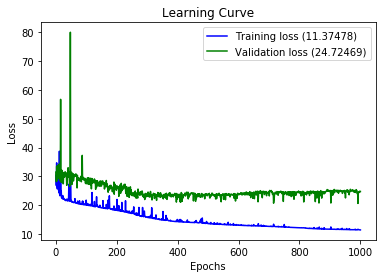

In [56]:
plot_history(hist)

#### Train: Dataset 3, Validate: Dataset 4

In [57]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open(prefix + 'models/mlp_notext_1/1545041016/architecture.json', 'r') as f:
    model = model_from_json(f.read())

from keras.optimizers import Adadelta, Nadam, SGD, Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00004, amsgrad=True)
#optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True)
#optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
    
# Load weights into the new model
model.load_weights(prefix + 'models/mlp_notext_1/1545041016/weights/val_loss-20.58_at_epoch-992.h5')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

In [58]:
import h5py

idx = 2
with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'r') as hdf5:
    to_normalize_cols = hdf5['Normalized Columns'][:]
    to_normalize_cols = [x.encode().decode('UTF-8') for x in to_normalize_cols]
    
    categorical_features = hdf5['Categorical Features'][:]
    categorical_features = [x.encode().decode('UTF-8') for x in categorical_features]
    
    X_to_normalized = hdf5['X_to_normalized'][:]
    X_categorical_features = hdf5['X_categorical_features'][:]
    y = hdf5['y'][:]
    
import h5py

idx = 3
with h5py.File(prefix + 'data/scaledtrain_notext_subset_0.25_{0}.hdf5'.format(idx), 'r') as hdf5:
    X_val_to_normalized = hdf5['X_to_normalized'][:]
    X_val_categorical_features = hdf5['X_categorical_features'][:]
    y_val = hdf5['y'][:]

In [59]:
print('Train:', (y > 0).sum() / len(y) * 100.00)
print('Val:', (y_val > 0).sum() / len(y_val) * 100.00)

Train: 65.4900787241993
Val: 66.25083081957155


In [60]:
print('Train:', (y <= 0).sum() / len(y) * 100.00)
print('Val:', (y_val <= 0).sum() / len(y_val) * 100.00)

Train: 34.5099212758007
Val: 33.749169180428446


In [62]:
from sklearn.preprocessing import MinMaxScaler

import pickle as pk

X_scaler = pk.load(open(prefix + 'models/mlp_notext_1/1545041016/scaler.pk', 'rb'))
X_to_normalized = X_scaler.fit_transform(X_to_normalized)
X_val_to_normalized = X_scaler.transform(X_val_to_normalized)

In [63]:
X_train = np.hstack((X_to_normalized, X_categorical_features))
X_train = pd.DataFrame(data=X_train, columns=to_normalize_cols + categorical_features)
print('Train:', X_train.shape)

X_val = np.hstack((X_val_to_normalized, X_val_categorical_features))
X_val = pd.DataFrame(data=X_val, columns=to_normalize_cols + categorical_features)
print('Val:', X_val.shape)

Train: (631572, 29)
Val: (645447, 29)


In [64]:
import os
import time

timestamp = int(time.time())

directory = prefix + 'models/mlp_notext_2/{0}/'.format(timestamp)
if not os.path.exists(directory + 'weights/'):
    os.makedirs(directory + 'weights/')

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

batch_size = 1191

# Tensorboard for learning curve
# Early stopping (to avoid overfitting)
# Model checkpoint (to save model preiodically)
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
#from keras.callbacks import TensorBoard

hist = History()
#early_stop = EarlyStopping(patience=10, monitor='val_mean_squared_logarithmic_error')
#tensorboard = TensorBoard(log_dir='./logs/mlp_word2vec/{}'.format(int(time.time())))
model_checkpt = ModelCheckpoint(directory + 'weights/val_loss-{val_loss:.2f}_at_epoch-{epoch:02d}.h5')

#model = base_model(X_train)

#model.fit(X_train[subsample], y_train[subsample],
model.fit(X_train, y,
          epochs=1000, batch_size=batch_size,
          callbacks=[hist, model_checkpt], #, early_stop, tensorboard],
          shuffle=True, validation_data=(X_val, y_val))

Train on 631572 samples, validate on 645447 samples
Epoch 1/1000
631572/631572 [==============================] - 4s 7us/step - loss: 28.9715 - val_loss: 15.7119
Epoch 2/1000
631572/631572 [==============================] - 3s 5us/step - loss: 18.5739 - val_loss: 15.1717
Epoch 3/1000
631572/631572 [==============================] - 3s 5us/step - loss: 21.1830 - val_loss: 15.9360
Epoch 4/1000
631572/631572 [==============================] - 3s 5us/step - loss: 16.6890 - val_loss: 14.8921
Epoch 5/1000
631572/631572 [==============================] - 3s 5us/step - loss: 15.8822 - val_loss: 14.5827
Epoch 6/1000
631572/631572 [==============================] - 3s 5us/step - loss: 15.0898 - val_loss: 14.0975
Epoch 7/1000
631572/631572 [==============================] - 3s 5us/step - loss: 15.1852 - val_loss: 14.2831
Epoch 8/1000
631572/631572 [==============================] - 3s 5us/step - loss: 14.6125 - val_loss: 13.9541
Epoch 9/1000
631572/631572 [==============================] - 3s 5us

631572/631572 [==============================] - 4s 6us/step - loss: 13.0311 - val_loss: 12.7896
Epoch 148/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.7086 - val_loss: 12.7035
Epoch 149/1000
631572/631572 [==============================] - 4s 6us/step - loss: 13.6366 - val_loss: 13.9936
Epoch 150/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.8617 - val_loss: 12.7125
Epoch 151/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.8820 - val_loss: 12.8081
Epoch 152/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.7310 - val_loss: 12.5562
Epoch 153/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.7456 - val_loss: 12.6547
Epoch 154/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.8138 - val_loss: 12.8734
Epoch 155/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.6747 - val_loss: 12.8460
Epoch 1

631572/631572 [==============================] - 4s 6us/step - loss: 9.7438 - val_loss: 12.2416
Epoch 294/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.6161 - val_loss: 12.4291
Epoch 295/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.6172 - val_loss: 12.0385
Epoch 296/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.4923 - val_loss: 25.0514
Epoch 297/1000
631572/631572 [==============================] - 4s 6us/step - loss: 10.7182 - val_loss: 12.2420
Epoch 298/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.6083 - val_loss: 12.1956
Epoch 299/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.6620 - val_loss: 12.2465
Epoch 300/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.5804 - val_loss: 12.2219
Epoch 301/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.5808 - val_loss: 12.0677
Epoch 302/1000

Epoch 367/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.2272 - val_loss: 12.2810
Epoch 368/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1312 - val_loss: 12.1678
Epoch 369/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1446 - val_loss: 12.2134
Epoch 370/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1110 - val_loss: 12.1284
Epoch 371/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1097 - val_loss: 12.1280
Epoch 372/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1175 - val_loss: 12.1688
Epoch 373/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1129 - val_loss: 12.2116
Epoch 374/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1064 - val_loss: 12.3193
Epoch 375/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.0837 - val_loss: 12.1296
E

Epoch 514/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.6367 - val_loss: 11.2985
Epoch 515/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.6362 - val_loss: 11.4934
Epoch 516/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.6279 - val_loss: 11.5515
Epoch 517/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.6403 - val_loss: 11.4242
Epoch 518/1000
631572/631572 [==============================] - 3s 5us/step - loss: 10.4289 - val_loss: 21.3264
Epoch 519/1000
631572/631572 [==============================] - 3s 5us/step - loss: 9.4826 - val_loss: 11.5546
Epoch 520/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.6452 - val_loss: 11.5944
Epoch 521/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.6247 - val_loss: 11.6134
Epoch 522/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.7702 - val_loss: 13.2876


Epoch 588/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4820 - val_loss: 11.1124
Epoch 589/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4631 - val_loss: 11.1018
Epoch 590/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4833 - val_loss: 11.0973
Epoch 591/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.5143 - val_loss: 11.0822
Epoch 592/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4727 - val_loss: 11.0766
Epoch 593/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4770 - val_loss: 11.1458
Epoch 594/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4708 - val_loss: 11.0700
Epoch 595/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4708 - val_loss: 11.1944
Epoch 596/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.4854 - val_loss: 11.0741
E

Epoch 662/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.4378 - val_loss: 10.9263
Epoch 663/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3768 - val_loss: 10.9991
Epoch 664/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3607 - val_loss: 10.9699
Epoch 665/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3639 - val_loss: 11.0194
Epoch 666/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3673 - val_loss: 11.0221
Epoch 667/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3938 - val_loss: 11.0701
Epoch 668/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3734 - val_loss: 11.0752
Epoch 669/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3567 - val_loss: 11.0218
Epoch 670/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3523 - val_loss: 10.8948
E

Epoch 736/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2600 - val_loss: 10.8551
Epoch 737/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2542 - val_loss: 10.7916
Epoch 738/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2442 - val_loss: 10.7516
Epoch 739/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2704 - val_loss: 10.8223
Epoch 740/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2443 - val_loss: 10.8496
Epoch 741/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2451 - val_loss: 10.8415
Epoch 742/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2428 - val_loss: 10.7790
Epoch 743/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2770 - val_loss: 10.8530
Epoch 744/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2400 - val_loss: 10.8977
E

Epoch 810/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.2076 - val_loss: 10.7043
Epoch 811/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.2454 - val_loss: 10.7221
Epoch 812/1000
631572/631572 [==============================] - 3s 5us/step - loss: 8.1839 - val_loss: 10.7093
Epoch 813/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1739 - val_loss: 10.7039
Epoch 814/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1732 - val_loss: 10.7545
Epoch 815/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.3618 - val_loss: 10.7070
Epoch 816/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2071 - val_loss: 10.7490
Epoch 817/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2084 - val_loss: 10.7481
Epoch 818/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1671 - val_loss: 10.7245
E

Epoch 884/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1144 - val_loss: 10.5476
Epoch 885/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1176 - val_loss: 10.6264
Epoch 886/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.5346 - val_loss: 10.4860
Epoch 887/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1962 - val_loss: 10.5120
Epoch 888/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1242 - val_loss: 10.5239
Epoch 889/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1192 - val_loss: 10.5169
Epoch 890/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1208 - val_loss: 10.5349
Epoch 891/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1401 - val_loss: 10.6675
Epoch 892/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1103 - val_loss: 10.5585
E

Epoch 958/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.0664 - val_loss: 10.5498
Epoch 959/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.0828 - val_loss: 10.5517
Epoch 960/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.0718 - val_loss: 10.6004
Epoch 961/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.0733 - val_loss: 10.5654
Epoch 962/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1087 - val_loss: 10.5097
Epoch 963/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1148 - val_loss: 10.5173
Epoch 964/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.1108 - val_loss: 10.5750
Epoch 965/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.2714 - val_loss: 10.3805
Epoch 966/1000
631572/631572 [==============================] - 4s 6us/step - loss: 8.0970 - val_loss: 10.4401
E

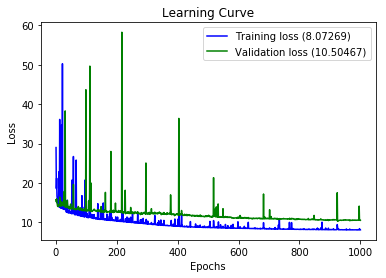

In [66]:
plot_history(hist)

#### Repeat training till val_loss < 1.0

Iteration 1 - Train Dataset 1, Validate Dataset 4

In [27]:
from keras.optimizers import Adadelta, Nadam, SGD, Adam
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

model_path='mlp_notext_2/1545044698'

optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000004, amsgrad=True)
model=customize_model(model_path,
                      weights_file='val_loss-10.23_at_epoch-925',
                      optimizer=optimizer)
                      #layer_op='insert', layer_id=1, layer=Dropout(0.05))

X_train, y_train, X_val, y_val = load_dataset(train_id=0, val_id=3, model_path=model_path)

model, hist, directory, timestamp = run_model(model, 'mlp_notext_n', X_train, y_train, X_val, y_val, batch_size=1191)

model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17      

Epoch 62/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.1155 - val_loss: 10.1746
Epoch 63/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.0821 - val_loss: 9.9628
Epoch 64/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.0641 - val_loss: 9.6164
Epoch 65/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.0672 - val_loss: 9.7503
Epoch 66/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.0408 - val_loss: 9.6426
Epoch 67/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.0218 - val_loss: 9.5448
Epoch 68/1000
610983/610983 [==============================] - 3s 5us/step - loss: 7.9935 - val_loss: 9.2973
Epoch 69/1000
610983/610983 [==============================] - 3s 5us/step - loss: 8.3556 - val_loss: 9.7561
Epoch 70/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.9774 - val_loss: 9.2798
Epoch 71/1000
6109

Epoch 210/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.9286 - val_loss: 11.8598
Epoch 211/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.9254 - val_loss: 11.8740
Epoch 212/1000
610983/610983 [==============================] - 3s 5us/step - loss: 7.0081 - val_loss: 10.4114
Epoch 213/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.9556 - val_loss: 12.5055
Epoch 214/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8830 - val_loss: 11.8342
Epoch 215/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8937 - val_loss: 11.7816
Epoch 216/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8931 - val_loss: 11.7658
Epoch 217/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.9948 - val_loss: 11.5133
Epoch 218/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8867 - val_loss: 11.4378
E

Epoch 284/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7814 - val_loss: 11.5830
Epoch 285/1000
610983/610983 [==============================] - 3s 6us/step - loss: 7.0157 - val_loss: 11.7780
Epoch 286/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8201 - val_loss: 11.3174
Epoch 287/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.7715 - val_loss: 11.5597
Epoch 288/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.7742 - val_loss: 11.6731
Epoch 289/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.7594 - val_loss: 11.8562
Epoch 290/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7846 - val_loss: 12.1713
Epoch 291/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7725 - val_loss: 11.8601
Epoch 292/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8728 - val_loss: 10.5494
E

Epoch 358/1000
610983/610983 [==============================] - 3s 5us/step - loss: 7.0733 - val_loss: 11.8006
Epoch 359/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8454 - val_loss: 10.4230
Epoch 360/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8844 - val_loss: 11.9595
Epoch 361/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7369 - val_loss: 11.9520
Epoch 362/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7141 - val_loss: 11.9757
Epoch 363/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7123 - val_loss: 11.3737
Epoch 364/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7477 - val_loss: 11.8442
Epoch 365/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7008 - val_loss: 12.0658
Epoch 366/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7039 - val_loss: 11.9829
E

Epoch 432/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6559 - val_loss: 11.7303
Epoch 433/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6603 - val_loss: 12.1531
Epoch 434/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6620 - val_loss: 11.7064
Epoch 435/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6533 - val_loss: 11.6744
Epoch 436/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6566 - val_loss: 11.8442
Epoch 437/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6516 - val_loss: 11.7862
Epoch 438/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6515 - val_loss: 11.8047
Epoch 439/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7595 - val_loss: 11.4362
Epoch 440/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6621 - val_loss: 11.1102
E

Epoch 506/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6598 - val_loss: 11.2303
Epoch 507/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6250 - val_loss: 11.6882
Epoch 508/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6197 - val_loss: 11.6604
Epoch 509/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6210 - val_loss: 11.5633
Epoch 510/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6171 - val_loss: 11.7461
Epoch 511/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6167 - val_loss: 11.8419
Epoch 512/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6162 - val_loss: 11.8088
Epoch 513/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6195 - val_loss: 11.8453
Epoch 514/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6187 - val_loss: 11.7814
E

Epoch 580/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6117 - val_loss: 11.8578
Epoch 581/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6745 - val_loss: 11.7504
Epoch 582/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6056 - val_loss: 11.7494
Epoch 583/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6065 - val_loss: 11.8329
Epoch 584/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6077 - val_loss: 11.8752
Epoch 585/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6087 - val_loss: 11.7007
Epoch 586/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6047 - val_loss: 11.7460
Epoch 587/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6053 - val_loss: 11.7385
Epoch 588/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6036 - val_loss: 11.7903
E

Epoch 654/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5883 - val_loss: 11.7872
Epoch 655/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5908 - val_loss: 11.8062
Epoch 656/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5934 - val_loss: 11.6405
Epoch 657/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5884 - val_loss: 11.8220
Epoch 658/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5893 - val_loss: 11.7694
Epoch 659/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.8810 - val_loss: 10.3025
Epoch 660/1000
610983/610983 [==============================] - 3s 5us/step - loss: 7.4851 - val_loss: 10.8120
Epoch 661/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.7083 - val_loss: 11.8825
Epoch 662/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.6250 - val_loss: 11.8675
E

Epoch 728/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5844 - val_loss: 11.4931
Epoch 729/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5717 - val_loss: 11.6588
Epoch 730/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5716 - val_loss: 11.7443
Epoch 731/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5672 - val_loss: 11.6488
Epoch 732/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5712 - val_loss: 11.7274
Epoch 733/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5709 - val_loss: 11.5548
Epoch 734/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5708 - val_loss: 11.6804
Epoch 735/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5699 - val_loss: 11.5396
Epoch 736/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5717 - val_loss: 11.6654
E

Epoch 802/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5635 - val_loss: 11.4850
Epoch 803/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5601 - val_loss: 11.6366
Epoch 804/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5611 - val_loss: 11.6011
Epoch 805/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5712 - val_loss: 11.5950
Epoch 806/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5591 - val_loss: 11.5942
Epoch 807/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5610 - val_loss: 11.6311
Epoch 808/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5585 - val_loss: 11.6495
Epoch 809/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5589 - val_loss: 11.6318
Epoch 810/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5860 - val_loss: 11.5452
E

Epoch 876/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5463 - val_loss: 11.6652
Epoch 877/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5446 - val_loss: 11.7055
Epoch 878/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5434 - val_loss: 11.6888
Epoch 879/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5460 - val_loss: 11.6566
Epoch 880/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5469 - val_loss: 11.6489
Epoch 881/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5431 - val_loss: 11.4556
Epoch 882/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5451 - val_loss: 11.6101
Epoch 883/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5430 - val_loss: 11.6774
Epoch 884/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5419 - val_loss: 11.6785
E

Epoch 950/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5566 - val_loss: 11.6731
Epoch 951/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5634 - val_loss: 11.3800
Epoch 952/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5547 - val_loss: 11.5025
Epoch 953/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5541 - val_loss: 11.5261
Epoch 954/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5455 - val_loss: 11.4431
Epoch 955/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5557 - val_loss: 11.3779
Epoch 956/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5399 - val_loss: 11.5177
Epoch 957/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5419 - val_loss: 11.4869
Epoch 958/1000
610983/610983 [==============================] - 3s 5us/step - loss: 6.5428 - val_loss: 11.3762
E

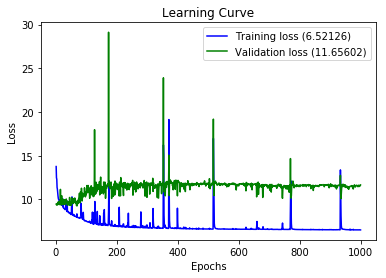

In [31]:
save_model(model, hist, directory)
plot_history(hist, add_title_text=' for Train Dataset 1, Validation Dataset 4 (Iteration 1)')

Iteration 1 - Train Dataset 2, Validate Dataset 4

In [32]:
from keras.optimizers import Adadelta, Nadam, SGD, Adam
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

model_path='mlp_notext_n/1545055042'

optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000004, amsgrad=True)
model=customize_model(model_path,
                      weights_file='val_loss-9.28_at_epoch-70',
                      optimizer=optimizer)
                      #layer_op='insert', layer_id=1, layer=Dropout(0.05))

X_train, y_train, X_val, y_val = load_dataset(train_id=1, val_id=3, model_path=model_path)

model, hist, directory, timestamp = run_model(model, 'mlp_notext_n', X_train, y_train, X_val, y_val, batch_size=1191)

model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17      

612198/612198 [==============================] - 3s 5us/step - loss: 7.6076 - val_loss: 9.5665
Epoch 136/1000
612198/612198 [==============================] - 3s 5us/step - loss: 7.5708 - val_loss: 10.3256
Epoch 137/1000
612198/612198 [==============================] - 3s 5us/step - loss: 7.6277 - val_loss: 10.6233
Epoch 138/1000
612198/612198 [==============================] - 3s 6us/step - loss: 7.5346 - val_loss: 10.1927
Epoch 139/1000
612198/612198 [==============================] - 3s 6us/step - loss: 7.5713 - val_loss: 10.2353
Epoch 140/1000
612198/612198 [==============================] - 3s 5us/step - loss: 7.5073 - val_loss: 10.3681
Epoch 141/1000
612198/612198 [==============================] - 3s 5us/step - loss: 7.6788 - val_loss: 10.4066
Epoch 142/1000
612198/612198 [==============================] - 3s 5us/step - loss: 7.4934 - val_loss: 10.2298
Epoch 143/1000
612198/612198 [==============================] - 3s 5us/step - loss: 7.4957 - val_loss: 10.5817
Epoch 144/1000
61

Epoch 209/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7716 - val_loss: 11.1194
Epoch 210/1000
612198/612198 [==============================] - 3s 6us/step - loss: 6.7590 - val_loss: 10.9249
Epoch 211/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7550 - val_loss: 11.0710
Epoch 212/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7519 - val_loss: 10.9485
Epoch 213/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7537 - val_loss: 10.8297
Epoch 214/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7391 - val_loss: 11.0896
Epoch 215/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7621 - val_loss: 10.9367
Epoch 216/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7747 - val_loss: 11.0736
Epoch 217/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7360 - val_loss: 11.2945
E

Epoch 283/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.7266 - val_loss: 10.7090
Epoch 284/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3902 - val_loss: 10.9315
Epoch 285/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3874 - val_loss: 10.9090
Epoch 286/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3982 - val_loss: 11.0378
Epoch 287/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3810 - val_loss: 10.9468
Epoch 288/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3837 - val_loss: 10.2449
Epoch 289/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3862 - val_loss: 10.9017
Epoch 290/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3489 - val_loss: 10.9488
Epoch 291/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.3811 - val_loss: 11.0153
E

Epoch 357/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.2091 - val_loss: 11.2579
Epoch 358/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.2014 - val_loss: 11.1858
Epoch 359/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.2001 - val_loss: 11.1729
Epoch 360/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.1890 - val_loss: 10.9965
Epoch 361/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.1922 - val_loss: 11.2509
Epoch 362/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.1959 - val_loss: 11.1208
Epoch 363/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.1842 - val_loss: 11.2131
Epoch 364/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.1830 - val_loss: 11.0107
Epoch 365/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.1807 - val_loss: 11.0907
E

Epoch 431/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.0398 - val_loss: 11.0055
Epoch 432/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.0168 - val_loss: 10.9740
Epoch 433/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.0131 - val_loss: 11.0950
Epoch 434/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.0054 - val_loss: 11.1144
Epoch 435/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.0127 - val_loss: 11.1167
Epoch 436/1000
612198/612198 [==============================] - 3s 5us/step - loss: 6.0082 - val_loss: 11.1342
Epoch 437/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.9936 - val_loss: 11.0735
Epoch 438/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.9916 - val_loss: 10.9656
Epoch 439/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.9853 - val_loss: 10.9582
E

Epoch 505/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.8776 - val_loss: 10.8010
Epoch 506/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.8700 - val_loss: 10.8952
Epoch 507/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.9089 - val_loss: 10.6002
Epoch 508/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.8745 - val_loss: 11.0081
Epoch 509/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.8684 - val_loss: 10.8860
Epoch 510/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.9287 - val_loss: 10.9205
Epoch 511/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.9998 - val_loss: 10.7806
Epoch 512/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.8739 - val_loss: 10.9051
Epoch 513/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.8585 - val_loss: 10.8250
E

Epoch 579/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6257 - val_loss: 11.3201
Epoch 580/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6316 - val_loss: 11.2229
Epoch 581/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6333 - val_loss: 11.1755
Epoch 582/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6205 - val_loss: 11.0604
Epoch 583/1000
612198/612198 [==============================] - 3s 6us/step - loss: 5.6179 - val_loss: 11.2383
Epoch 584/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6239 - val_loss: 11.3016
Epoch 585/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6192 - val_loss: 11.2334
Epoch 586/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6233 - val_loss: 11.3872
Epoch 587/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.6129 - val_loss: 11.1842
E

Epoch 653/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.5048 - val_loss: 11.0593
Epoch 654/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.5002 - val_loss: 10.9862
Epoch 655/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4978 - val_loss: 11.1241
Epoch 656/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.5017 - val_loss: 11.1862
Epoch 657/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.5016 - val_loss: 11.1707
Epoch 658/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4886 - val_loss: 11.1619
Epoch 659/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4861 - val_loss: 11.1790
Epoch 660/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4844 - val_loss: 11.1894
Epoch 661/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4816 - val_loss: 11.0252
E

Epoch 727/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4079 - val_loss: 11.0543
Epoch 728/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4003 - val_loss: 11.3039
Epoch 729/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4004 - val_loss: 11.0394
Epoch 730/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3970 - val_loss: 11.3172
Epoch 731/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3996 - val_loss: 11.3258
Epoch 732/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3968 - val_loss: 11.2708
Epoch 733/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3972 - val_loss: 10.8923
Epoch 734/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.4311 - val_loss: 11.0446
Epoch 735/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3940 - val_loss: 11.3266
E

Epoch 801/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3259 - val_loss: 11.5195
Epoch 802/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3282 - val_loss: 11.4659
Epoch 803/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3219 - val_loss: 11.3703
Epoch 804/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3244 - val_loss: 11.4503
Epoch 805/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3247 - val_loss: 11.4340
Epoch 806/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3164 - val_loss: 11.4349
Epoch 807/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3226 - val_loss: 11.3309
Epoch 808/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3189 - val_loss: 11.4239
Epoch 809/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.3202 - val_loss: 11.4989
E

Epoch 875/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2877 - val_loss: 11.4320
Epoch 876/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2777 - val_loss: 11.5211
Epoch 877/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2688 - val_loss: 11.4646
Epoch 878/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2775 - val_loss: 11.2955
Epoch 879/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2726 - val_loss: 11.4457
Epoch 880/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2712 - val_loss: 11.4098
Epoch 881/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2741 - val_loss: 11.2483
Epoch 882/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2658 - val_loss: 11.3988
Epoch 883/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2856 - val_loss: 11.4948
E

Epoch 949/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2242 - val_loss: 11.3880
Epoch 950/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2259 - val_loss: 11.3260
Epoch 951/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2553 - val_loss: 11.3560
Epoch 952/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2360 - val_loss: 11.4909
Epoch 953/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2241 - val_loss: 11.4321
Epoch 954/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2223 - val_loss: 11.5936
Epoch 955/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2405 - val_loss: 11.4414
Epoch 956/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2274 - val_loss: 11.5322
Epoch 957/1000
612198/612198 [==============================] - 3s 5us/step - loss: 5.2400 - val_loss: 11.4953
E

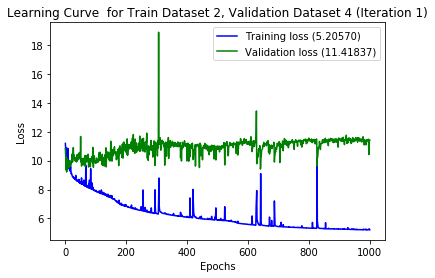

In [33]:
save_model(model, hist, directory)
plot_history(hist, add_title_text=' for Train Dataset 2, Validation Dataset 4 (Iteration 1)')

Iteration 1 - Train Dataset 3, Validate Dataset 4

In [310]:
from keras.optimizers import Adadelta, Nadam, SGD, Adam
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

model_path='mlp_notext_n/1545058481'

optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000004, amsgrad=True)
model=customize_model(model_path,
                      weights_file='val_loss-9.22_at_epoch-05',
                      optimizer=optimizer)
                      #layer_op='insert', layer_id=1, layer=Dropout(0.05))

X_train, y_train, X_val, y_val = load_dataset(train_id=2, val_id=3, model_path=model_path)

model, hist, directory, timestamp = run_model(model, 'mlp_notext_n', X_train, y_train, X_val, y_val, batch_size=1191)

model loaded
weights loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)          

631572/631572 [==============================] - 4s 6us/step - loss: 7.5002 - val_loss: 9.1435
Epoch 63/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.5557 - val_loss: 9.1701
Epoch 64/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.4814 - val_loss: 9.2152
Epoch 65/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.4784 - val_loss: 9.1162
Epoch 66/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.4782 - val_loss: 9.1722
Epoch 67/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.6997 - val_loss: 8.9666
Epoch 68/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.4652 - val_loss: 9.1080
Epoch 69/1000
631572/631572 [==============================] - 4s 6us/step - loss: 9.1927 - val_loss: 9.0888
Epoch 70/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.4836 - val_loss: 9.0982
Epoch 71/1000
631572/631572 [====

Epoch 137/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1534 - val_loss: 8.9485
Epoch 138/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1418 - val_loss: 8.9525
Epoch 139/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1391 - val_loss: 8.9129
Epoch 140/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1830 - val_loss: 8.9429
Epoch 141/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1463 - val_loss: 8.8564
Epoch 142/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1261 - val_loss: 8.9646
Epoch 143/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1243 - val_loss: 8.9197
Epoch 144/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1621 - val_loss: 8.9447
Epoch 145/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.1517 - val_loss: 8.9023
Epoch 146/

631572/631572 [==============================] - 4s 6us/step - loss: 6.6407 - val_loss: 8.6680
Epoch 286/1000
631572/631572 [==============================] - 4s 6us/step - loss: 7.0204 - val_loss: 8.8980
Epoch 287/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.6893 - val_loss: 8.6511
Epoch 288/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.9395 - val_loss: 8.9467
Epoch 289/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.6714 - val_loss: 8.7193
Epoch 290/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.6384 - val_loss: 8.6442
Epoch 291/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.6502 - val_loss: 8.6579
Epoch 292/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.6457 - val_loss: 8.7244
Epoch 293/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.6877 - val_loss: 8.6572
Epoch 294/1000
631572/631

631572/631572 [==============================] - 4s 6us/step - loss: 6.3506 - val_loss: 8.4036
Epoch 434/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3364 - val_loss: 8.7115
Epoch 435/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3577 - val_loss: 8.5742
Epoch 436/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3873 - val_loss: 8.4229
Epoch 437/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3669 - val_loss: 8.2849
Epoch 438/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.5506 - val_loss: 8.5544
Epoch 439/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3379 - val_loss: 8.4210
Epoch 440/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3367 - val_loss: 8.3834
Epoch 441/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.3207 - val_loss: 8.5083
Epoch 442/1000
631572/631

631572/631572 [==============================] - 4s 6us/step - loss: 6.2323 - val_loss: 8.5284
Epoch 582/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1433 - val_loss: 8.6736
Epoch 583/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1805 - val_loss: 8.8873
Epoch 584/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1609 - val_loss: 8.6664
Epoch 585/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1626 - val_loss: 8.4081
Epoch 586/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1579 - val_loss: 8.7023
Epoch 587/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1572 - val_loss: 8.3717
Epoch 588/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1393 - val_loss: 8.6217
Epoch 589/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.2710 - val_loss: 8.6990
Epoch 590/1000
631572/631

631572/631572 [==============================] - 4s 6us/step - loss: 6.0029 - val_loss: 8.5323
Epoch 730/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.9720 - val_loss: 8.6100
Epoch 731/1000
631572/631572 [==============================] - 4s 7us/step - loss: 5.9685 - val_loss: 8.6906
Epoch 732/1000
631572/631572 [==============================] - 4s 7us/step - loss: 6.0578 - val_loss: 8.7940
Epoch 733/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.9588 - val_loss: 8.8112
Epoch 734/1000
631572/631572 [==============================] - 4s 7us/step - loss: 5.9690 - val_loss: 8.7436
Epoch 735/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.0780 - val_loss: 8.9443
Epoch 736/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.9560 - val_loss: 8.8786
Epoch 737/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.1131 - val_loss: 8.9143
Epoch 738/1000
631572/631

631572/631572 [==============================] - 4s 6us/step - loss: 5.9084 - val_loss: 9.3245
Epoch 878/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.8351 - val_loss: 9.0951
Epoch 879/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.9279 - val_loss: 9.1350
Epoch 880/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.8497 - val_loss: 9.0200
Epoch 881/1000
631572/631572 [==============================] - 4s 6us/step - loss: 6.0192 - val_loss: 9.4541
Epoch 882/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.8427 - val_loss: 9.2125
Epoch 883/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.8479 - val_loss: 9.0625
Epoch 884/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.8308 - val_loss: 8.7183
Epoch 885/1000
631572/631572 [==============================] - 4s 6us/step - loss: 5.8770 - val_loss: 9.1491
Epoch 886/1000
631572/631

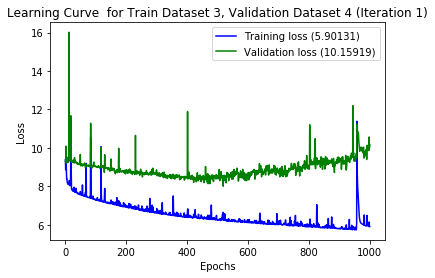

In [311]:
save_model(model, hist, directory)
plot_history(hist, add_title_text=' for Train Dataset 3, Validation Dataset 4 (Iteration 1)')

Iteration 2 - Train Dataset 1, Validate Dataset 4

In [314]:
from keras.optimizers import Adadelta, Nadam, SGD, Adam
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

model_path='mlp_notext_n/1545106554'

optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000004, amsgrad=True)
model=customize_model(model_path,
                      weights_file='val_loss-8.01_at_epoch-519',
                      optimizer=optimizer,
                      layer_op='insert', layer_id=1, layer=Dropout(0.125))

X_train, y_train, X_val, y_val = load_dataset(train_id=0, val_id=3, model_path=model_path)

model, hist, directory, timestamp = run_model(model, 'mlp_notext_n', X_train, y_train, X_val, y_val, batch_size=1191)

model loaded
weights loaded
Old Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("de..., outputs=Tensor("de...)`
  if sys.path[0] == '':


New Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8_input (InputLayer)   (None, 29)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       


610983/610983 [==============================] - 4s 6us/step - loss: 18.4294 - val_loss: 14.1039
Epoch 132/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.3917 - val_loss: 14.0712
Epoch 133/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.3805 - val_loss: 14.0219
Epoch 134/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.3040 - val_loss: 13.9323
Epoch 135/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.2359 - val_loss: 13.8861
Epoch 136/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.2330 - val_loss: 13.9025
Epoch 137/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.1894 - val_loss: 13.9425
Epoch 138/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.1269 - val_loss: 13.9689
Epoch 139/1000
610983/610983 [==============================] - 4s 6us/step - loss: 18.0837 - val_loss: 13.8961
Epoch 1

610983/610983 [==============================] - 4s 6us/step - loss: 12.6131 - val_loss: 11.3371
Epoch 278/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.6222 - val_loss: 11.3011
Epoch 279/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.5611 - val_loss: 11.2043
Epoch 280/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.5899 - val_loss: 11.2741
Epoch 281/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.4912 - val_loss: 11.1886
Epoch 282/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.5111 - val_loss: 11.1857
Epoch 283/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.4683 - val_loss: 11.3372
Epoch 284/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.3782 - val_loss: 11.1649
Epoch 285/1000
610983/610983 [==============================] - 4s 6us/step - loss: 12.3445 - val_loss: 11.2469
Epoch 2

610983/610983 [==============================] - 4s 6us/step - loss: 10.0160 - val_loss: 10.2291
Epoch 424/1000
610983/610983 [==============================] - 4s 6us/step - loss: 10.0904 - val_loss: 10.1888
Epoch 425/1000
610983/610983 [==============================] - 4s 6us/step - loss: 10.0193 - val_loss: 10.1072
Epoch 426/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.9784 - val_loss: 10.1408
Epoch 427/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.9853 - val_loss: 10.2974
Epoch 428/1000
610983/610983 [==============================] - 4s 6us/step - loss: 10.0132 - val_loss: 10.2314
Epoch 429/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.9854 - val_loss: 10.0106
Epoch 430/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.9810 - val_loss: 10.1218
Epoch 431/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.9489 - val_loss: 10.1346
Epoch 432/10

610983/610983 [==============================] - 4s 6us/step - loss: 9.2520 - val_loss: 9.9767
Epoch 498/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.2265 - val_loss: 9.8222
Epoch 499/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.2192 - val_loss: 9.7513
Epoch 500/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.2017 - val_loss: 9.9581
Epoch 501/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.2094 - val_loss: 10.0707
Epoch 502/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.1447 - val_loss: 10.0726
Epoch 503/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.1625 - val_loss: 9.9004
Epoch 504/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.2039 - val_loss: 10.1539
Epoch 505/1000
610983/610983 [==============================] - 4s 6us/step - loss: 9.1512 - val_loss: 9.9752
Epoch 506/1000
610983/

610983/610983 [==============================] - 4s 6us/step - loss: 8.0949 - val_loss: 9.6916
Epoch 646/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.1082 - val_loss: 9.9667
Epoch 647/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.1104 - val_loss: 9.8150
Epoch 648/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.1282 - val_loss: 9.6866
Epoch 649/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.0626 - val_loss: 9.9914
Epoch 650/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.1259 - val_loss: 9.7284
Epoch 651/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.1066 - val_loss: 9.9597
Epoch 652/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.0297 - val_loss: 10.0619
Epoch 653/1000
610983/610983 [==============================] - 4s 6us/step - loss: 8.0695 - val_loss: 9.7831
Epoch 654/1000
610983/61

610983/610983 [==============================] - 4s 6us/step - loss: 7.2771 - val_loss: 9.9732
Epoch 794/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2314 - val_loss: 10.2048
Epoch 795/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2004 - val_loss: 10.1769
Epoch 796/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2265 - val_loss: 10.4035
Epoch 797/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2240 - val_loss: 10.1644
Epoch 798/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2162 - val_loss: 9.8450
Epoch 799/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2073 - val_loss: 10.2194
Epoch 800/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2612 - val_loss: 10.2219
Epoch 801/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.2588 - val_loss: 10.4220
Epoch 802/1000
610

610983/610983 [==============================] - 4s 6us/step - loss: 7.0057 - val_loss: 10.0163
Epoch 868/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.0002 - val_loss: 10.0877
Epoch 869/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.0556 - val_loss: 10.1892
Epoch 870/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.0238 - val_loss: 10.1968
Epoch 871/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.0123 - val_loss: 9.9481
Epoch 872/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.0091 - val_loss: 10.1733
Epoch 873/1000
610983/610983 [==============================] - 4s 6us/step - loss: 7.0011 - val_loss: 10.2127
Epoch 874/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.9940 - val_loss: 10.1489
Epoch 875/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.9688 - val_loss: 10.0692
Epoch 876/1000
61

610983/610983 [==============================] - 4s 6us/step - loss: 6.8803 - val_loss: 10.0017
Epoch 942/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8681 - val_loss: 10.1180
Epoch 943/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8668 - val_loss: 10.1424
Epoch 944/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8490 - val_loss: 10.0725
Epoch 945/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8455 - val_loss: 10.0786
Epoch 946/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8588 - val_loss: 10.2084
Epoch 947/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8741 - val_loss: 10.1711
Epoch 948/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8341 - val_loss: 10.1238
Epoch 949/1000
610983/610983 [==============================] - 4s 6us/step - loss: 6.8759 - val_loss: 10.2331
Epoch 950/1000
6

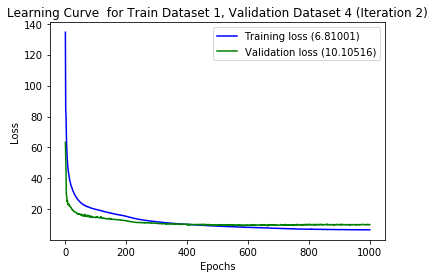

In [315]:
save_model(model, hist, directory)
plot_history(hist, add_title_text=' for Train Dataset 1, Validation Dataset 4 (Iteration 2)')

### Learning time series revenue

In [185]:
target = 'totals.transactionRevenue'

In [186]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
channelGrouping                                 903653 non-null int64
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null int64
sessionId                                       903653 non-null int64
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null int64
device.deviceCategory                           903653 non-null int64
device.operatingSystem                          903653 non-null int64
geoNetwork.city                                 903653 non-null int64
geoNetwork.continent                            903653 non-null int64
geoNetwork.country                              9

In [187]:
categorical_features = ['channelGrouping', 'device.browser', 'device.deviceCategory', 
                        'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 
                        'geoNetwork.metro', 'geoNetwork.region', 'geoNetwork.subContinent', 
                        'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 
                        'trafficSource.isTrueDirect', 'trafficSource.medium', 'trafficSource.source']

In [188]:
other_cols = []

for col in df_train.columns:
    if not col in categorical_features and col != target:
        other_cols.append(col)
print('Train', other_cols)

Train ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'geoNetwork.networkDomain', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot']


In [189]:
columns=other_cols + categorical_features
y = df_train.loc[:, target]
X_train = np.hstack((df_train.loc[:, other_cols].values,
                      df_train.loc[:, categorical_features].values))
X_train = pd.DataFrame(data=X_train, columns=columns)
X_train.shape

(903653, 29)

In [190]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 29 columns):
date                                            903653 non-null float64
fullVisitorId                                   903653 non-null float64
sessionId                                       903653 non-null float64
visitId                                         903653 non-null float64
visitNumber                                     903653 non-null float64
visitStartTime                                  903653 non-null float64
geoNetwork.networkDomain                        903653 non-null float64
totals.bounces                                  903653 non-null float64
totals.hits                                     903653 non-null float64
totals.newVisits                                903653 non-null float64
totals.pageviews                                903653 non-null float64
trafficSource.adwordsClickInfo.gclId            903653 non-null float64
trafficSource.adwordsClic

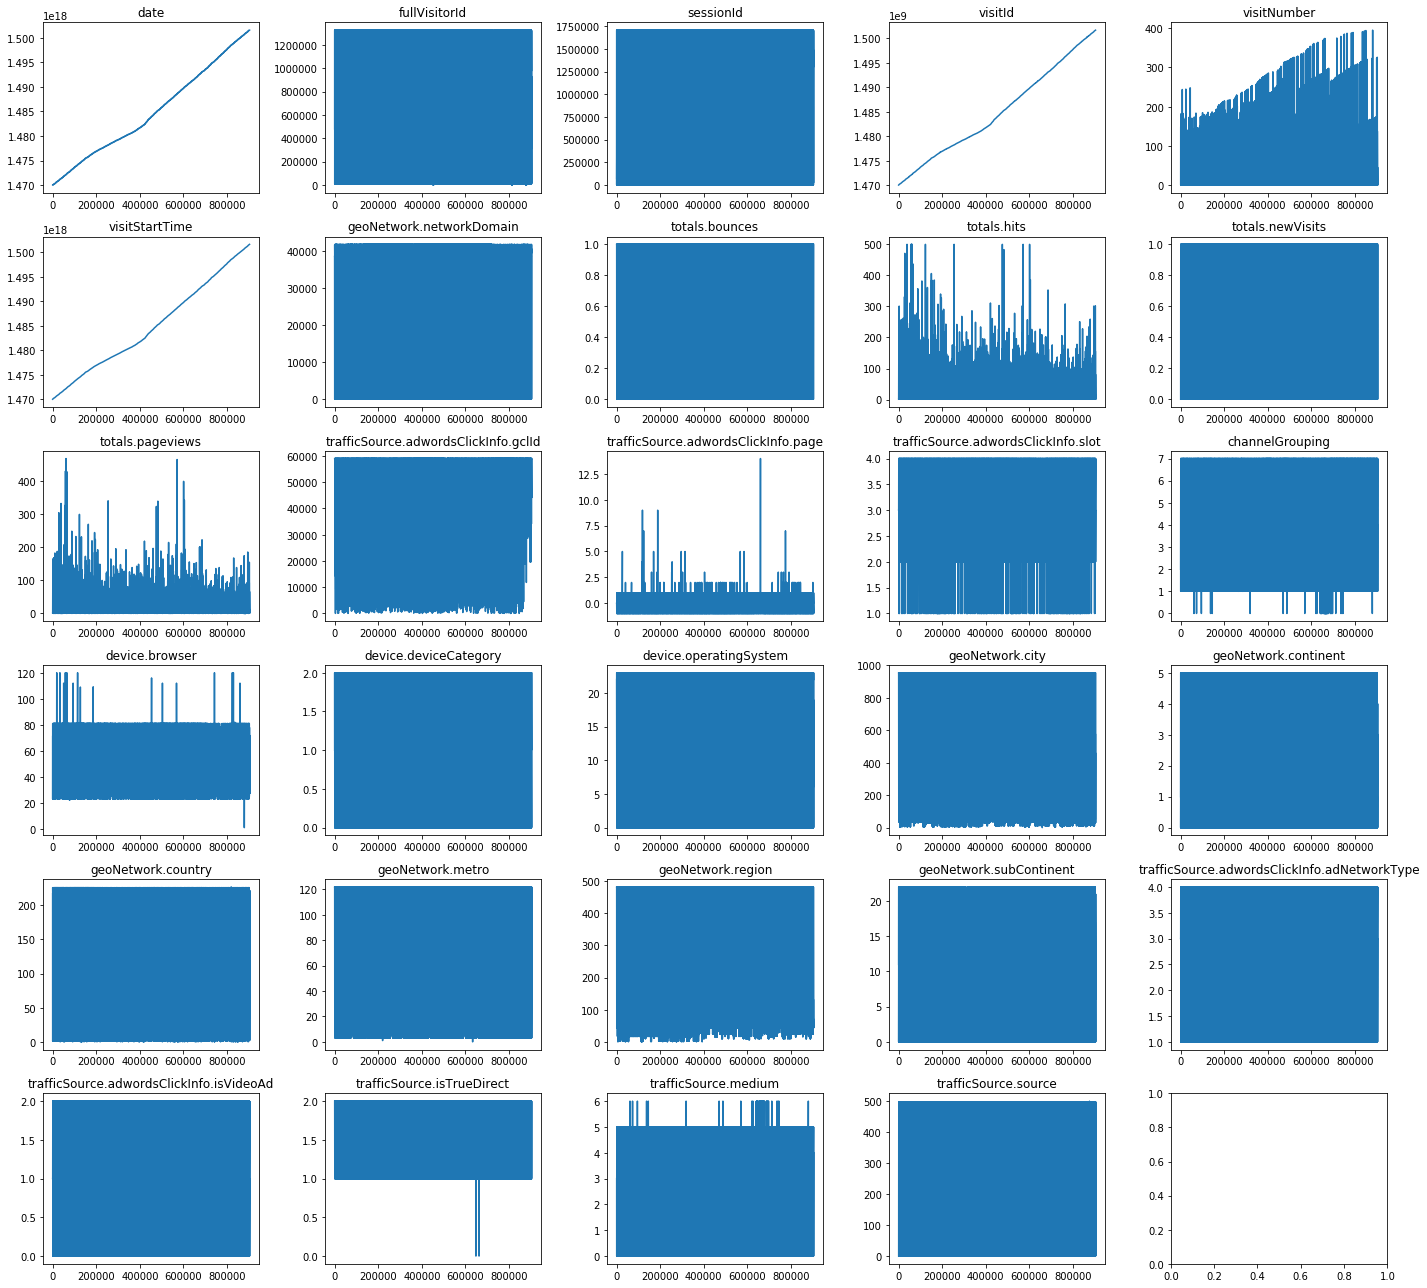

In [40]:
fig, ax = plt.subplots(6, 5, figsize=(20, 18))
for col, sub in zip(X_train.columns, ax.ravel()):
    sub.plot(X_train[col])
    sub.set(title=col)

plt.tight_layout()
plt.show()

In [191]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y, train_size=10000, shuffle=False)
X_train.shape

c:\program files\python36\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(10000, 29)

In [90]:
X_train_1 = X_train.drop(['date', 'visitId', 'visitNumber', 'visitStartTime'], axis=1)
X_val_1 = X_val.drop(['date', 'visitId', 'visitNumber', 'visitStartTime'], axis=1)

print('Train:', X_train_1.shape)
print('Val:', X_val_1.shape)

Train: (722922, 25)
Val: (180731, 25)


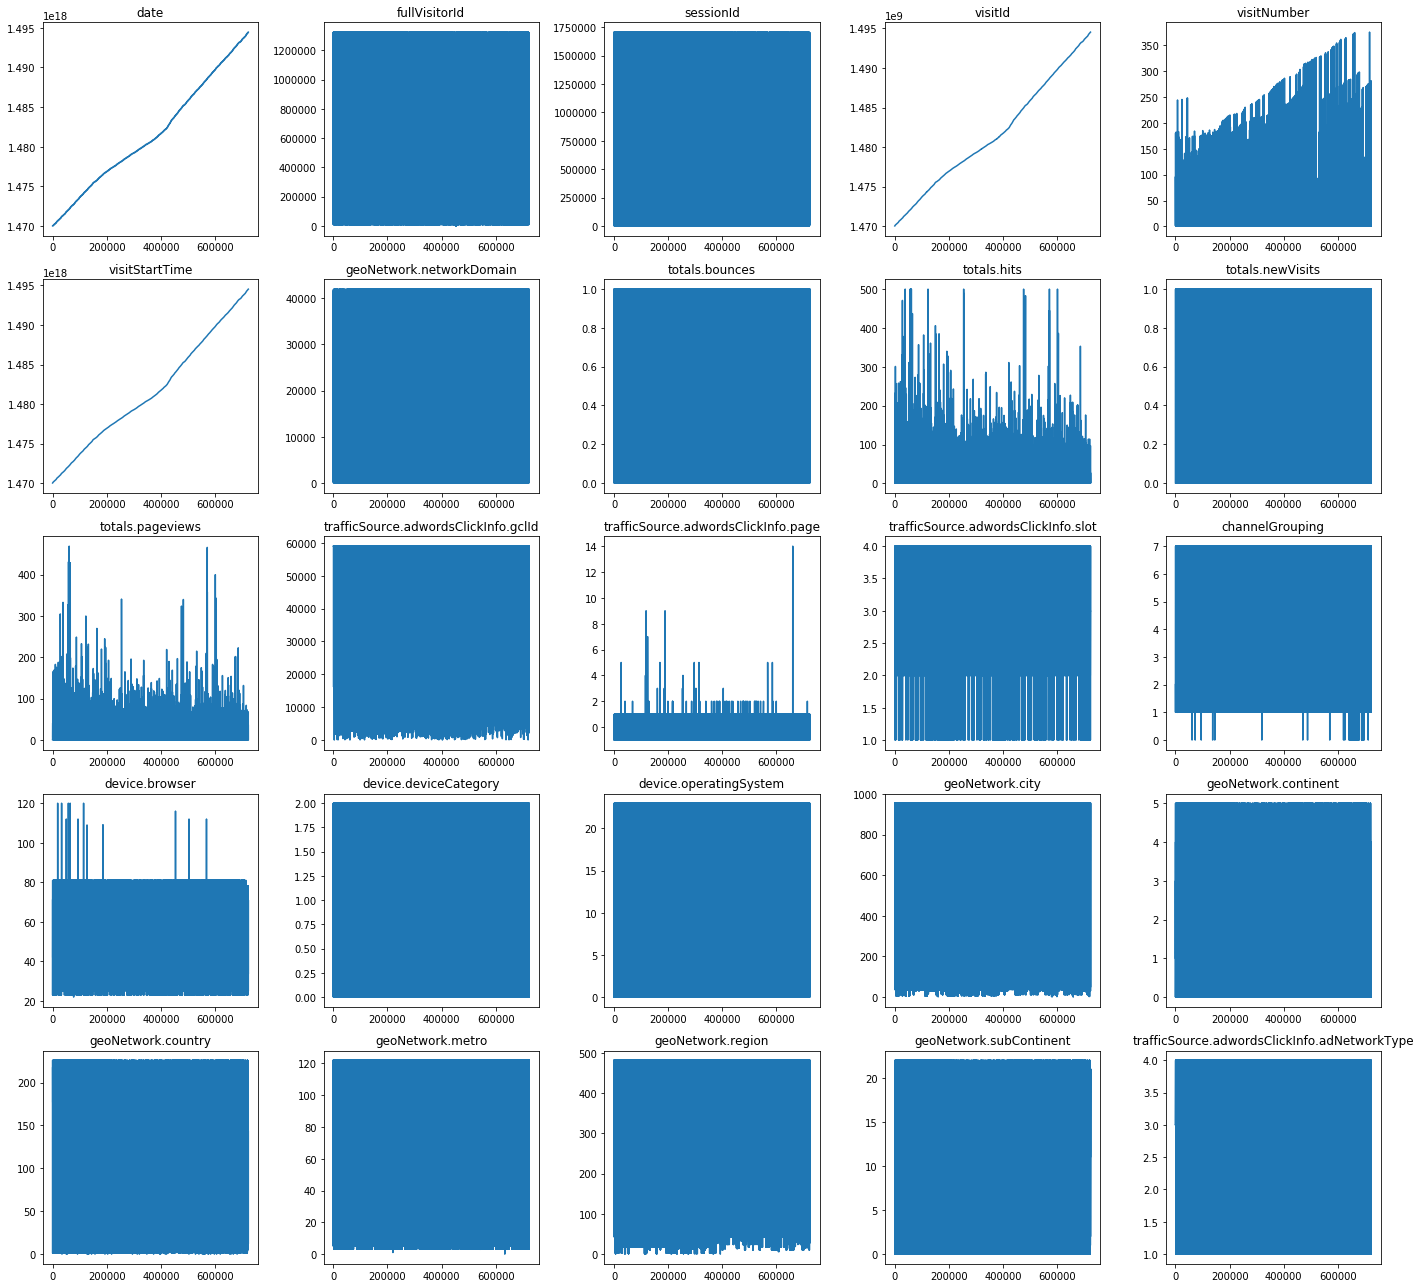

In [43]:
fig, ax = plt.subplots(5, 5, figsize=(20, 18))
for col, sub in zip(X_train.columns, ax.ravel()):
    sub.plot(X_train[col])
    sub.set(title=col)

plt.tight_layout()
plt.show()

In [73]:
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

# Model reconstruction from JSON file
with open(prefix + 'models/mlp_notext_n/1545058481/architecture.json', 'r') as f:
    model = model_from_json(f.read()) 

print(model.summary())
#model = insert_intermediate_layer_in_keras(model, 6, Dropout(0.2))

from keras.optimizers import Adadelta, Nadam, SGD, Adam
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

# Load trained weights into the model
model.load_weights(prefix + 'models/mlp_notext_n/1545058481/weights/val_loss-9.22_at_epoch-05.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

#### Training RNN with predicted Customer Revenue

In [3]:
target = 'totals.transactionRevenue'

In [4]:
df_train = pd.read_csv(prefix + 'data/cleanedtrain_notext.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
channelGrouping                                 903653 non-null int64
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null int64
sessionId                                       903653 non-null int64
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null int64
device.deviceCategory                           903653 non-null int64
device.operatingSystem                          903653 non-null int64
geoNetwork.city                                 903653 non-null int64
geoNetwork.continent                            903653 non-null int64
geoNetwork.country                              9

In [5]:
categorical_features = ['channelGrouping', 'device.browser', 'device.deviceCategory', 
                        'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 
                        'geoNetwork.metro', 'geoNetwork.region', 'geoNetwork.subContinent', 
                        'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 
                        'trafficSource.isTrueDirect', 'trafficSource.medium', 'trafficSource.source']

In [6]:
other_cols = []

for col in df_train.columns:
    if not col in categorical_features and col != target:
        other_cols.append(col)
print('Train', other_cols)

Train ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'geoNetwork.networkDomain', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot']


In [53]:
columns=other_cols + categorical_features
y = df_train.loc[:, target]
X = np.hstack((df_train.loc[:, other_cols].values,
               df_train.loc[:, categorical_features].values))
X = pd.DataFrame(data=X, columns=columns)
X.shape

(903653, 29)

In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 29 columns):
date                                            903653 non-null float64
fullVisitorId                                   903653 non-null float64
sessionId                                       903653 non-null float64
visitId                                         903653 non-null float64
visitNumber                                     903653 non-null float64
visitStartTime                                  903653 non-null float64
geoNetwork.networkDomain                        903653 non-null float64
totals.bounces                                  903653 non-null float64
totals.hits                                     903653 non-null float64
totals.newVisits                                903653 non-null float64
totals.pageviews                                903653 non-null float64
trafficSource.adwordsClickInfo.gclId            903653 non-null float64
trafficSource.adwordsClic

In [246]:
time_window = 10000
#start_index = 0
if start_index + time_window >= len(X):
    print('Training completed')
else:
    # train_test_split
    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(X[start_index:], y[start_index:], train_size=time_window, shuffle=False)
    start_index = min(start_index + time_window, len(X))
    X_train.shape

c:\program files\python36\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [248]:
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

# Model reconstruction from JSON file
with open(prefix + 'models/mlp_notext_n/1545058481/architecture.json', 'r') as f:
    model = model_from_json(f.read()) 

print(model.summary())

from keras.optimizers import Adadelta, Nadam, SGD, Adam
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

# Load trained weights into the model
model.load_weights(prefix + 'models/mlp_notext_n/1545058481/weights/val_loss-9.22_at_epoch-05.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

In [249]:
y_pred = model.predict(X_train)

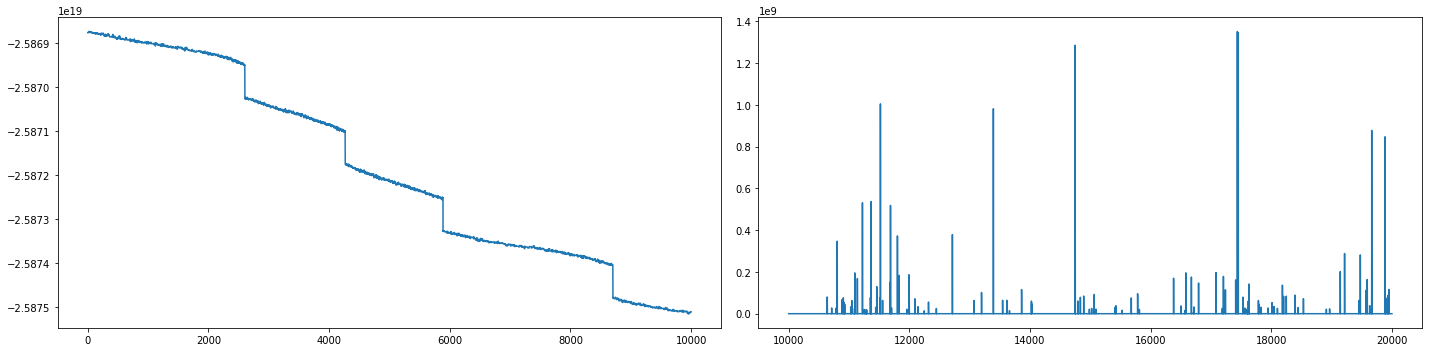

In [250]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

y_pred = pd.DataFrame(data=y_pred, columns=[target])
ax[0].plot(y_pred)
ax[1].plot(y_train)
plt.tight_layout()
plt.show()

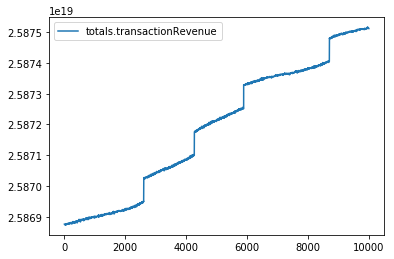

In [251]:
y_pred = abs(y_pred)
y_pred.plot()

In [254]:
X_train = np.hstack((X_train, y_pred))

In [257]:
X_val = X_val.iloc[:time_window].values
y_val = y_val.iloc[:time_window].values

In [258]:
y_val_pred = abs(model.predict(X_val))

In [259]:
X_val = np.hstack((X_val, y_val_pred))

Text(0.5, 1.0, 'date')

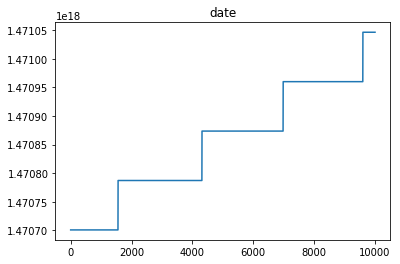

In [261]:
pd.DataFrame(data=X_val, columns=columns+[target]).iloc[:,0].plot().set_title(columns[0])

In [262]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(copy=False, feature_range=(-1, 1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.fit_transform(X_val)

In [263]:
pd.DataFrame(data=X_train).describe()

0             1             2             3             4   \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.073200     -0.007964     -0.009056      0.032378     -0.988096   
std        0.704728      0.578655      0.576677      0.634248      0.077695   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -1.000000     -0.510353     -0.511219     -0.592464     -1.000000   
50%        0.000000     -0.015595     -0.014209      0.116836     -1.000000   
75%        0.500000      0.496279      0.488633      0.580736     -1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 5             6             7             8             9   \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.032386      0.388024     -0.006600     -0.962567      0.592200   
std        0.634247      0.625731      1.000028      0.104279      0.805831   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.592464     -0.086609     -1.000000     -1.000000      1.000000   
50%        0.116836      0.787642     -1.000000     -0.992218      1.000000   
75%        0.580736      0.845779      1.000000     -0.968872      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           ...                 20            21            22            23  \
count      ...       10000.000000  10000.000000  10000.000000  10000.000000   
mean       ...           0.438352      0.857079      0.531079      0.118655   
std        ...           0.598850      0.348835      0.677358      0.443286   
min        ...          -1.000000     -1.000000     -1.000000     -1.000000   
25%        ...          -0.111111      1.000000     -0.013542      0.000000   
50%        ...           0.848889      1.000000      1.000000      0.000000   
75%        ...           0.920000      1.000000      1.000000      0.363636   
max        ...           1.000000      1.000000      1.000000      1.000000   

                 24            25            26            27            28  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.314800     -0.010000     -0.694400      0.642920      0.144039   
std        0.186470      0.159695      0.719625      0.463848      0.731917   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.333333      0.000000     -1.000000      0.600000     -0.168675   
50%        0.333333      0.000000     -1.000000      0.600000     -0.168675   
75%        0.333333      0.000000     -1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 29  
count  10000.000000  
mean      -0.018863  
std        0.661200  
min       -1.000000  
25%       -0.780822  
50%        0.057534  
75%        0.539726  
max        1.000000  

[8 rows x 30 columns]

In [264]:
pd.DataFrame(data=X_val).describe()

0             1             2             3             4   \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.122200      0.006176      0.004944     -0.048861     -0.989103   
std        0.561426      0.576276      0.578913      0.564862      0.060538   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.500000     -0.483885     -0.493065     -0.525999     -1.000000   
50%        0.000000      0.003302      0.006372     -0.020603     -1.000000   
75%        0.500000      0.499809      0.498925      0.483543     -1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 5             6             7             8             9   \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.048857      0.433794     -0.039800     -0.976818      0.517800   
std        0.564862      0.605836      0.999258      0.060198      0.855544   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.525999      0.175055     -1.000000     -1.000000      1.000000   
50%       -0.020603      0.845779     -1.000000     -0.995745      1.000000   
75%        0.483543      0.845779      1.000000     -0.978723      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           ...                 20            21            22            23  \
count      ...       10000.000000  10000.000000  10000.000000  10000.000000   
mean       ...           0.492611      0.815519      0.433737      0.105136   
std        ...           0.582148      0.386374      0.725354      0.423578   
min        ...          -1.000000     -1.000000     -1.000000     -1.000000   
25%        ...           0.075556      0.613445     -0.287500      0.000000   
50%        ...           0.902222      1.000000      1.000000      0.000000   
75%        ...           0.920000      1.000000      1.000000      0.363636   
max        ...           1.000000      1.000000      1.000000      1.000000   

                 24            25            26            27            28  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.320200     -0.004900     -0.686000      0.669200      0.148001   
std        0.174762      0.157094      0.727638      0.421916      0.718033   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.333333      0.000000     -1.000000      0.600000     -0.168675   
50%        0.333333      0.000000     -1.000000      0.600000     -0.168675   
75%        0.333333      0.000000     -1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 29  
count  10000.000000  
mean      -0.083551  
std        0.555967  
min       -1.000000  
25%       -0.508824  
50%       -0.010294  
75%        0.492647  
max        1.000000  

[8 rows x 30 columns]

In [239]:
from keras.layers import GRU, Concatenate, LSTM, Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adadelta, Adam
from keras.backend import int_shape

batch_size = 5
sequence_len = 1

np.random.seed()

rnn_model = Sequential()

rnn_model.add(LSTM(units=8, activation='tanh',
                   recurrent_activation='hard_sigmoid',
                   use_bias=True, 
                   kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', 
                   unit_forget_bias=False, 
                   kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                   kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                   dropout=0.00, recurrent_dropout=0.00, 
                   implementation=1, 
                   return_sequences=True, return_state=False, go_backwards=False, 
                   stateful=True, 
                   input_shape=(sequence_len, X_train.shape[1]),
                   batch_input_shape=(batch_size, sequence_len, X_train.shape[1]),
                   unroll=False))

rnn_model.add(LSTM(units=1, activation='tanh',
                   recurrent_activation='hard_sigmoid',
                   use_bias=True, 
                   kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', 
                   unit_forget_bias=False, 
                   kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                   kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                   dropout=0.00, recurrent_dropout=0.00, 
                   implementation=1, 
                   return_sequences=False, return_state=False, go_backwards=False, 
                   stateful=True, 
                   input_shape=(sequence_len, X_train.shape[1]),
                   batch_input_shape=(batch_size, sequence_len, X_train.shape[1]),
                   unroll=False))

rnn_model.add(Dense(1, name='dense_8')) # output with no activation (regression)
print(rnn_model.summary()) 

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00004, amsgrad=True)
rnn_model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (5, 1, 8)                 1248      
_________________________________________________________________
lstm_31 (LSTM)               (5, 1)                    40        
_________________________________________________________________
dense_8 (Dense)              (5, 1)                    2         
Total params: 1,290
Trainable params: 1,290
Non-trainable params: 0
_________________________________________________________________
None


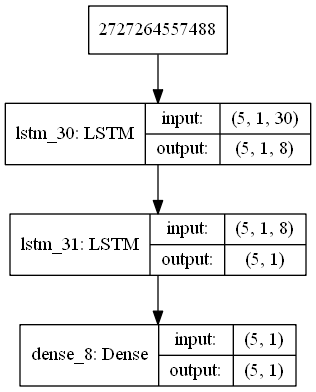

In [240]:
from keras.utils.vis_utils import plot_model

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

plot_model(rnn_model, show_shapes=True, show_layer_names=True, to_file=prefix + 'architecture.png')

from IPython.display import Image
Image(filename=prefix + 'architecture.png')

In [241]:
import os
import time

timestamp = int(time.time())

directory = prefix + 'models/mlp_rnn_notext/{0}/'.format(timestamp)
if not os.path.exists(directory + 'weights/'):
    os.makedirs(directory + 'weights/')

# Tensorboard for learning curve
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

hist = History()
model_checkpt = ModelCheckpoint(directory + 'weights/val_loss-{val_loss:.2f}_at_epoch-{epoch:02d}.h5')

rnn_model.fit(X_train.reshape(-1, 1, X_train.shape[1]), y_train,
              epochs=100, batch_size=batch_size,
              callbacks=[hist, model_checkpt], #, early_stop, tensorboard],
              shuffle=False,
              validation_data=(X_val.reshape(-1, 1, X_val.shape[1]), y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 22s 2ms/step - loss: 2.0907 - val_loss: 3.8025
Epoch 2/100
10000/10000 [==============================] - 20s 2ms/step - loss: 2.0824 - val_loss: 3.7989
Epoch 3/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0859 - val_loss: 3.7923
Epoch 4/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0859 - val_loss: 3.7904
Epoch 5/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0903 - val_loss: 3.7841
Epoch 6/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0869 - val_loss: 3.7827
Epoch 7/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0831 - val_loss: 3.7796
Epoch 8/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0829 - val_loss: 3.7789
Epoch 9/100
10000/10000 [==============================] - 21s 2ms/step - loss: 2.0802 - val_loss: 3.7

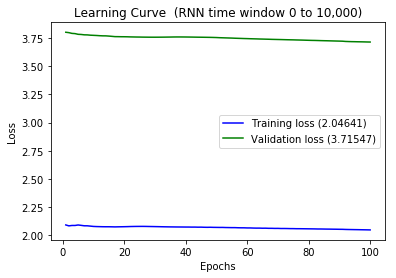

In [242]:
save_model(rnn_model, hist, directory)
plot_history(hist, add_title_text=' (RNN time window 0 to 10,000)')

In [271]:
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, concatenate, Embedding, BatchNormalization, Reshape

# Model reconstruction from JSON file
with open(prefix + 'models/mlp_rnn_notext/1545099707/architecture.json', 'r') as f:
    rnn_model = model_from_json(f.read()) 

print(rnn_model.summary())
#model = insert_intermediate_layer_in_keras(model, 6, Dropout(0.2))

from keras.optimizers import Adadelta, Nadam, SGD, Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00004, amsgrad=True)
rnn_model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

# Load trained weights into the model
rnn_model.load_weights(prefix + 'models/mlp_rnn_notext/1545099707/weights/val_loss-3.72_at_epoch-100.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (5, 1, 8)                 1248      
_________________________________________________________________
lstm_31 (LSTM)               (5, 1)                    40        
_________________________________________________________________
dense_8 (Dense)              (5, 1)                    2         
Total params: 1,290
Trainable params: 1,290
Non-trainable params: 0
_________________________________________________________________
None


In [272]:
import os
import time

timestamp = int(time.time())

directory = prefix + 'models/mlp_rnn_notext/{0}/'.format(timestamp)
if not os.path.exists(directory + 'weights/'):
    os.makedirs(directory + 'weights/')

# Tensorboard for learning curve
# Early stopping (to avoid overfitting)
# Model checkpoint (to save model preiodically)
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

hist = History()
model_checkpt = ModelCheckpoint(directory + 'weights/val_loss-{val_loss:.2f}_at_epoch-{epoch:02d}.h5')

rnn_model.fit(X_train.reshape(-1, 1, X_train.shape[1]), y_train,
              epochs=100, batch_size=batch_size,
              callbacks=[hist, model_checkpt], #, early_stop, tensorboard],
              shuffle=False,
              validation_data=(X_val.reshape(-1, 1, X_val.shape[1]), y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 23s 2ms/step - loss: 3.7079 - val_loss: 5.7577
Epoch 2/100
10000/10000 [==============================] - 20s 2ms/step - loss: 3.6883 - val_loss: 5.7559
Epoch 3/100
10000/10000 [==============================] - 20s 2ms/step - loss: 3.6776 - val_loss: 5.7561
Epoch 4/100
10000/10000 [==============================] - 20s 2ms/step - loss: 3.6698 - val_loss: 5.7557
Epoch 5/100
10000/10000 [==============================] - 20s 2ms/step - loss: 3.6621 - val_loss: 5.7563
Epoch 6/100
10000/10000 [==============================] - 21s 2ms/step - loss: 3.6534 - val_loss: 5.7558
Epoch 7/100
10000/10000 [==============================] - 22s 2ms/step - loss: 3.6453 - val_loss: 5.7565
Epoch 8/100
10000/10000 [==============================] - 22s 2ms/step - loss: 3.6402 - val_loss: 5.7515
Epoch 9/100
10000/10000 [==============================] - 21s 2ms/step - loss: 3.6372 - val_loss: 5.7

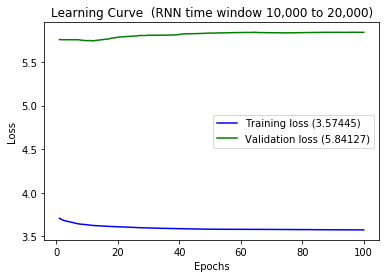

In [273]:
save_model(rnn_model, hist, directory)
plot_history(hist, add_title_text=' (RNN time window 10,000 to 20,000)')

### Predicting Revenue

In [286]:
# one step forecast (predict one at a time)
pred = []
batch_size = 5
sequence_len = 1

for i in range(20000):
    X_t = X.iloc[i]
    X_t = X_t.values.reshape(sequence_len, X_t.shape[0])
    yhat = abs(model.predict(X_t, batch_size=batch_size))
    #print(yhat.flatten()[0])
    pred.append(yhat.flatten()[0])

In [287]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y[:20000], pred)

1986.1992106295854

In [291]:
# take the inverse difference to reconstruct y
# then plot

# last value of training data
start_value = y[20000-1]

# compute the predictions using cumulative sum
df_reconstructed = pd.DataFrame({'predictions': [start_value] + pred}).cumsum()
df_reconstructed['truth'] = y[:20000+1]

df_reconstructed.head()

predictions  truth
0  0.000000e+00    0.0
1  2.586264e+19    0.0
2  5.172530e+19    0.0
3  7.758796e+19    0.0
4  1.034506e+20    0.0

In [292]:
df_reconstructed.tail()

predictions  truth
19996  5.172728e+23    0.0
19997  5.172987e+23    0.0
19998  5.173245e+23    0.0
19999  5.173504e+23    0.0
20000  5.173763e+23    0.0

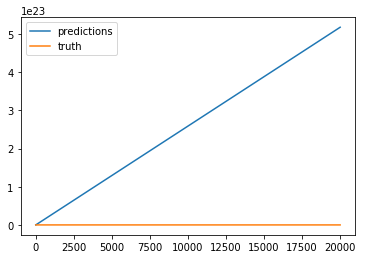

In [293]:
df_reconstructed.plot()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 4 columns):
totals.transactionRevenue    20000 non-null float64
prev_revenue                 20000 non-null float64
pred_diff                    20000 non-null float64
pred_revenue                 20000 non-null float64
dtypes: float64(4)
memory usage: 781.2 KB
None


c:\program files\python36\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


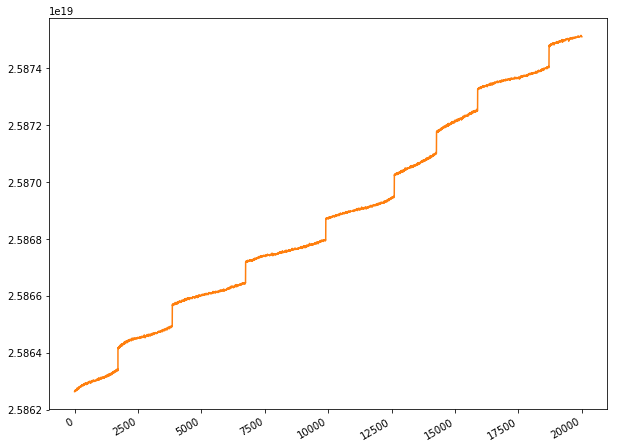

In [303]:
truth_revenue = y.iloc[:20000+1]
print(type(truth_revenue))

# get the previous exchange rate so that we can predict
# the current one using this formula:
#   current = previous + pred_diff
df_short_term = pd.DataFrame(data=truth_revenue)
df_short_term['prev_revenue'] = df_short_term.shift(1)
df_short_term.dropna(inplace=True)

df_short_term['pred_diff'] = pred
df_short_term['pred_revenue'] = df_short_term['prev_revenue'] + pred

print(df_short_term.info())

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_short_term.loc[:, #df_short_term.index > '2015-07', 
                          ['revenue', 'pred_revenue']])

fig.autofmt_xdate()
#df_short_term.head()